In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt, cm as cm, colors as colors, __version__ as mplver
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from glob import glob
from astropy.timeseries import LombScargle
from astropy.table import Table
from astropy import __version__ as apver
from scipy import stats, __version__ as spver
import warnings
from TESStools import *
from tqdm.notebook import tqdm

In [2]:
print(np.__version__,pd.__version__,mplver,apver,spver)

1.20.3 1.3.0 3.3.4 4.2.1 1.6.2


# Let's load in our sample and see how it looks in the HR diagram!

In [3]:
instability_strip = pd.read_table('paper_2020/instability_strip.txt',sep=' ',index_col=False)
#instability strip from Geneva models, Anderson et al. (2016) for omega_i = 0, Z=0.006

#We're also going to need our stars...
cool_sgs = pd.read_csv('sample.csv',index_col=0)
cool_sgs

RA        Dec      dist      pmRA     pmDec     Tmag  \
tic                                                                      
179437520  79.971947 -68.067692  0.091019  1.593040  0.205590   9.8540   
404965649  85.373961 -69.415872  0.060785  1.788260  0.708052  11.0373   
40185978   76.968537 -70.434641  0.160504  2.140400  0.216068  11.1070   
181445828  13.765720 -73.010260  0.236534  0.797799 -1.265550  11.0965   
182735393  15.655494 -72.273615  0.085619  0.942084 -1.163470  11.1242   
...              ...        ...       ...       ...       ...      ...   
182730317  16.205624 -72.106040  0.055346  0.664882 -1.272430  11.4480   
180792170  12.659946 -73.471738  0.058121  0.543531 -1.243180  11.1544   
182905190  16.484663 -72.329100  0.057287  0.986675 -1.257930  11.6057   
180609595  12.262374 -73.361369  0.051217  0.833683 -1.258340  11.2247   
180609829  11.911418 -73.130237  0.102761  0.841840 -1.167340  10.9665   

           ContRatio  SpT     CommonName      MKType  ... SpecSource  Gal  \
tic                                                   ...                   
179437520        NaN  RSG   SV* HV  2450          M1  ...          N  LMC   
404965649        NaN  RSG   CPD-69   502         NaN  ...          N  LMC   
40185978         NaN  RSG    SK -70   80          M0  ...          N  LMC   
181445828        NaN  YSG       PMMR  74    G6Ia-Iab  ...          N  SMC   
182735393        NaN  YSG       PMMR 135  G6.5Ia-Iab  ...          N  SMC   
...              ...  ...            ...         ...  ...        ...  ...   
182730317        NaN  YSG        RMC  36      B3:Iak  ...          N  SMC   
180792170        NaN  YSG      HD   5045       B2:I:  ...          N  SMC   
182905190        NaN  YSG  LHA 115-S  45     B1.5Ia:  ...          N  SMC   
180609595        NaN  YSG      HD   4862         B2I  ...          N  SMC   
180609829        NaN  YSG    BBB SMC 259      B5I(e)  ...          N  SMC   

            w1mag   w2mag   w3mag  w4mag     RA_tic    Dec_tic  \
tic                                                              
179437520   6.841   6.993   6.134  4.754  79.971929 -68.067717   
404965649   8.013   8.161   7.247  5.391  85.374008 -69.415869   
40185978    8.254   8.398   8.099  7.782  76.968487 -70.434600   
181445828   8.741   8.825   8.492  8.396        NaN        NaN   
182735393   8.807   8.863   8.588  8.536        NaN        NaN   
...           ...     ...     ...    ...        ...        ...   
182730317  11.204  11.192  11.061  9.228        NaN        NaN   
180792170  10.896  10.853  10.681  9.225        NaN        NaN   
182905190  11.192  11.145  10.694  7.014        NaN        NaN   
180609595  10.897  10.912  11.226  9.238        NaN        NaN   
180609829  12.036  12.045  12.627  8.956        NaN        NaN   

                     source_id  n_sectors  
tic                                        
179437520  4658722752228316160         12  
404965649  4657625263503324544         11  
40185978   4652070290243179776         12  
181445828  4685961808462981248          1  
182735393  4687498998758427520          1  
...                        ...        ...  
182730317  4687507584364583040          1  
180792170  4685876050900042880          2  
182905190  4687488965713758336          2  
180609595  4685926800243102848          2  
180609829  4685948275085827328          2  

[201 rows x 24 columns]

## What about all of their SLFV? We did the fit with emcee in `emcee_SLFV.ipynb` so let's load that in along with our results from `prewhitening.py` where we look for pulsations...

In [4]:
slfv_params = pd.read_csv('slfv_params.csv',index_col=0)
inspected = pd.read_csv('prewhitening.csv',index_col=0)
merged = pd.merge(cool_sgs,slfv_params,left_index=True,right_index=True)
merged = pd.merge(merged,inspected,left_index=True,right_index=True)
merged.to_csv('merged.csv')
merged

RA        Dec      dist      pmRA     pmDec     Tmag  \
179437520  79.971947 -68.067692  0.091019  1.593040  0.205590   9.8540   
404965649  85.373961 -69.415872  0.060785  1.788260  0.708052  11.0373   
40185978   76.968537 -70.434641  0.160504  2.140400  0.216068  11.1070   
181445828  13.765720 -73.010260  0.236534  0.797799 -1.265550  11.0965   
182735393  15.655494 -72.273615  0.085619  0.942084 -1.163470  11.1242   
...              ...        ...       ...       ...       ...      ...   
182730317  16.205624 -72.106040  0.055346  0.664882 -1.272430  11.4480   
180792170  12.659946 -73.471738  0.058121  0.543531 -1.243180  11.1544   
182905190  16.484663 -72.329100  0.057287  0.986675 -1.257930  11.6057   
180609595  12.262374 -73.361369  0.051217  0.833683 -1.258340  11.2247   
180609829  11.911418 -73.130237  0.102761  0.841840 -1.167340  10.9665   

           ContRatio  SpT     CommonName      MKType  ... gamma_err_hi  \
179437520        NaN  RSG   SV* HV  2450          M1  ...     0.068952   
404965649        NaN  RSG   CPD-69   502         NaN  ...     0.054547   
40185978         NaN  RSG    SK -70   80          M0  ...     0.106133   
181445828        NaN  YSG       PMMR  74    G6Ia-Iab  ...     0.617187   
182735393        NaN  YSG       PMMR 135  G6.5Ia-Iab  ...     1.022825   
...              ...  ...            ...         ...  ...          ...   
182730317        NaN  YSG        RMC  36      B3:Iak  ...     0.245336   
180792170        NaN  YSG      HD   5045       B2:I:  ...     0.116150   
182905190        NaN  YSG  LHA 115-S  45     B1.5Ia:  ...     0.126873   
180609595        NaN  YSG      HD   4862         B2I  ...     0.109677   
180609829        NaN  YSG    BBB SMC 259      B5I(e)  ...     0.169216   

             alphaw  alphaw_err_lo  alphaw_err_hi n_peaks highest_amp  \
179437520  0.001787       0.000002       0.000002     1.0    0.000112   
404965649  0.001792       0.000002       0.000002     2.0    0.000632   
40185978   0.001661       0.000002       0.000002     2.0    0.000682   
181445828  0.006040       0.000028       0.000028     4.0    0.000860   
182735393  0.006129       0.000028       0.000028     0.0         NaN   
...             ...            ...            ...     ...         ...   
182730317  0.006435       0.000032       0.000032     5.0    0.004196   
180792170  0.004529       0.000015       0.000016     1.0    0.000226   
182905190  0.004593       0.000016       0.000016     6.0    0.002484   
180609595  0.004260       0.000014       0.000014     1.0    0.002578   
180609829  0.004164       0.000013       0.000013     0.0         NaN   

           highest_amp_error        f0  f0_error   lc_length  
179437520           0.000004  0.888836  0.000056  353.438659  
404965649           0.000008  0.185827  0.000022  327.866488  
40185978            0.000007  0.189058  0.000016  353.438654  
181445828           0.000026  0.703227  0.000701   23.854007  
182735393                NaN       NaN       NaN   23.854045  
...                      ...       ...       ...         ...  
182730317           0.000065  0.076864  0.000358   23.854054  
180792170           0.000040  4.052713  0.001974   49.426456  
182905190           0.000047  0.189142  0.000212   49.426575  
180609595           0.000032  0.181989  0.000140   49.426461  
180609829                NaN       NaN       NaN   49.426475  

[201 rows x 42 columns]

  0%|          | 0/201 [00:00<?, ?it/s]

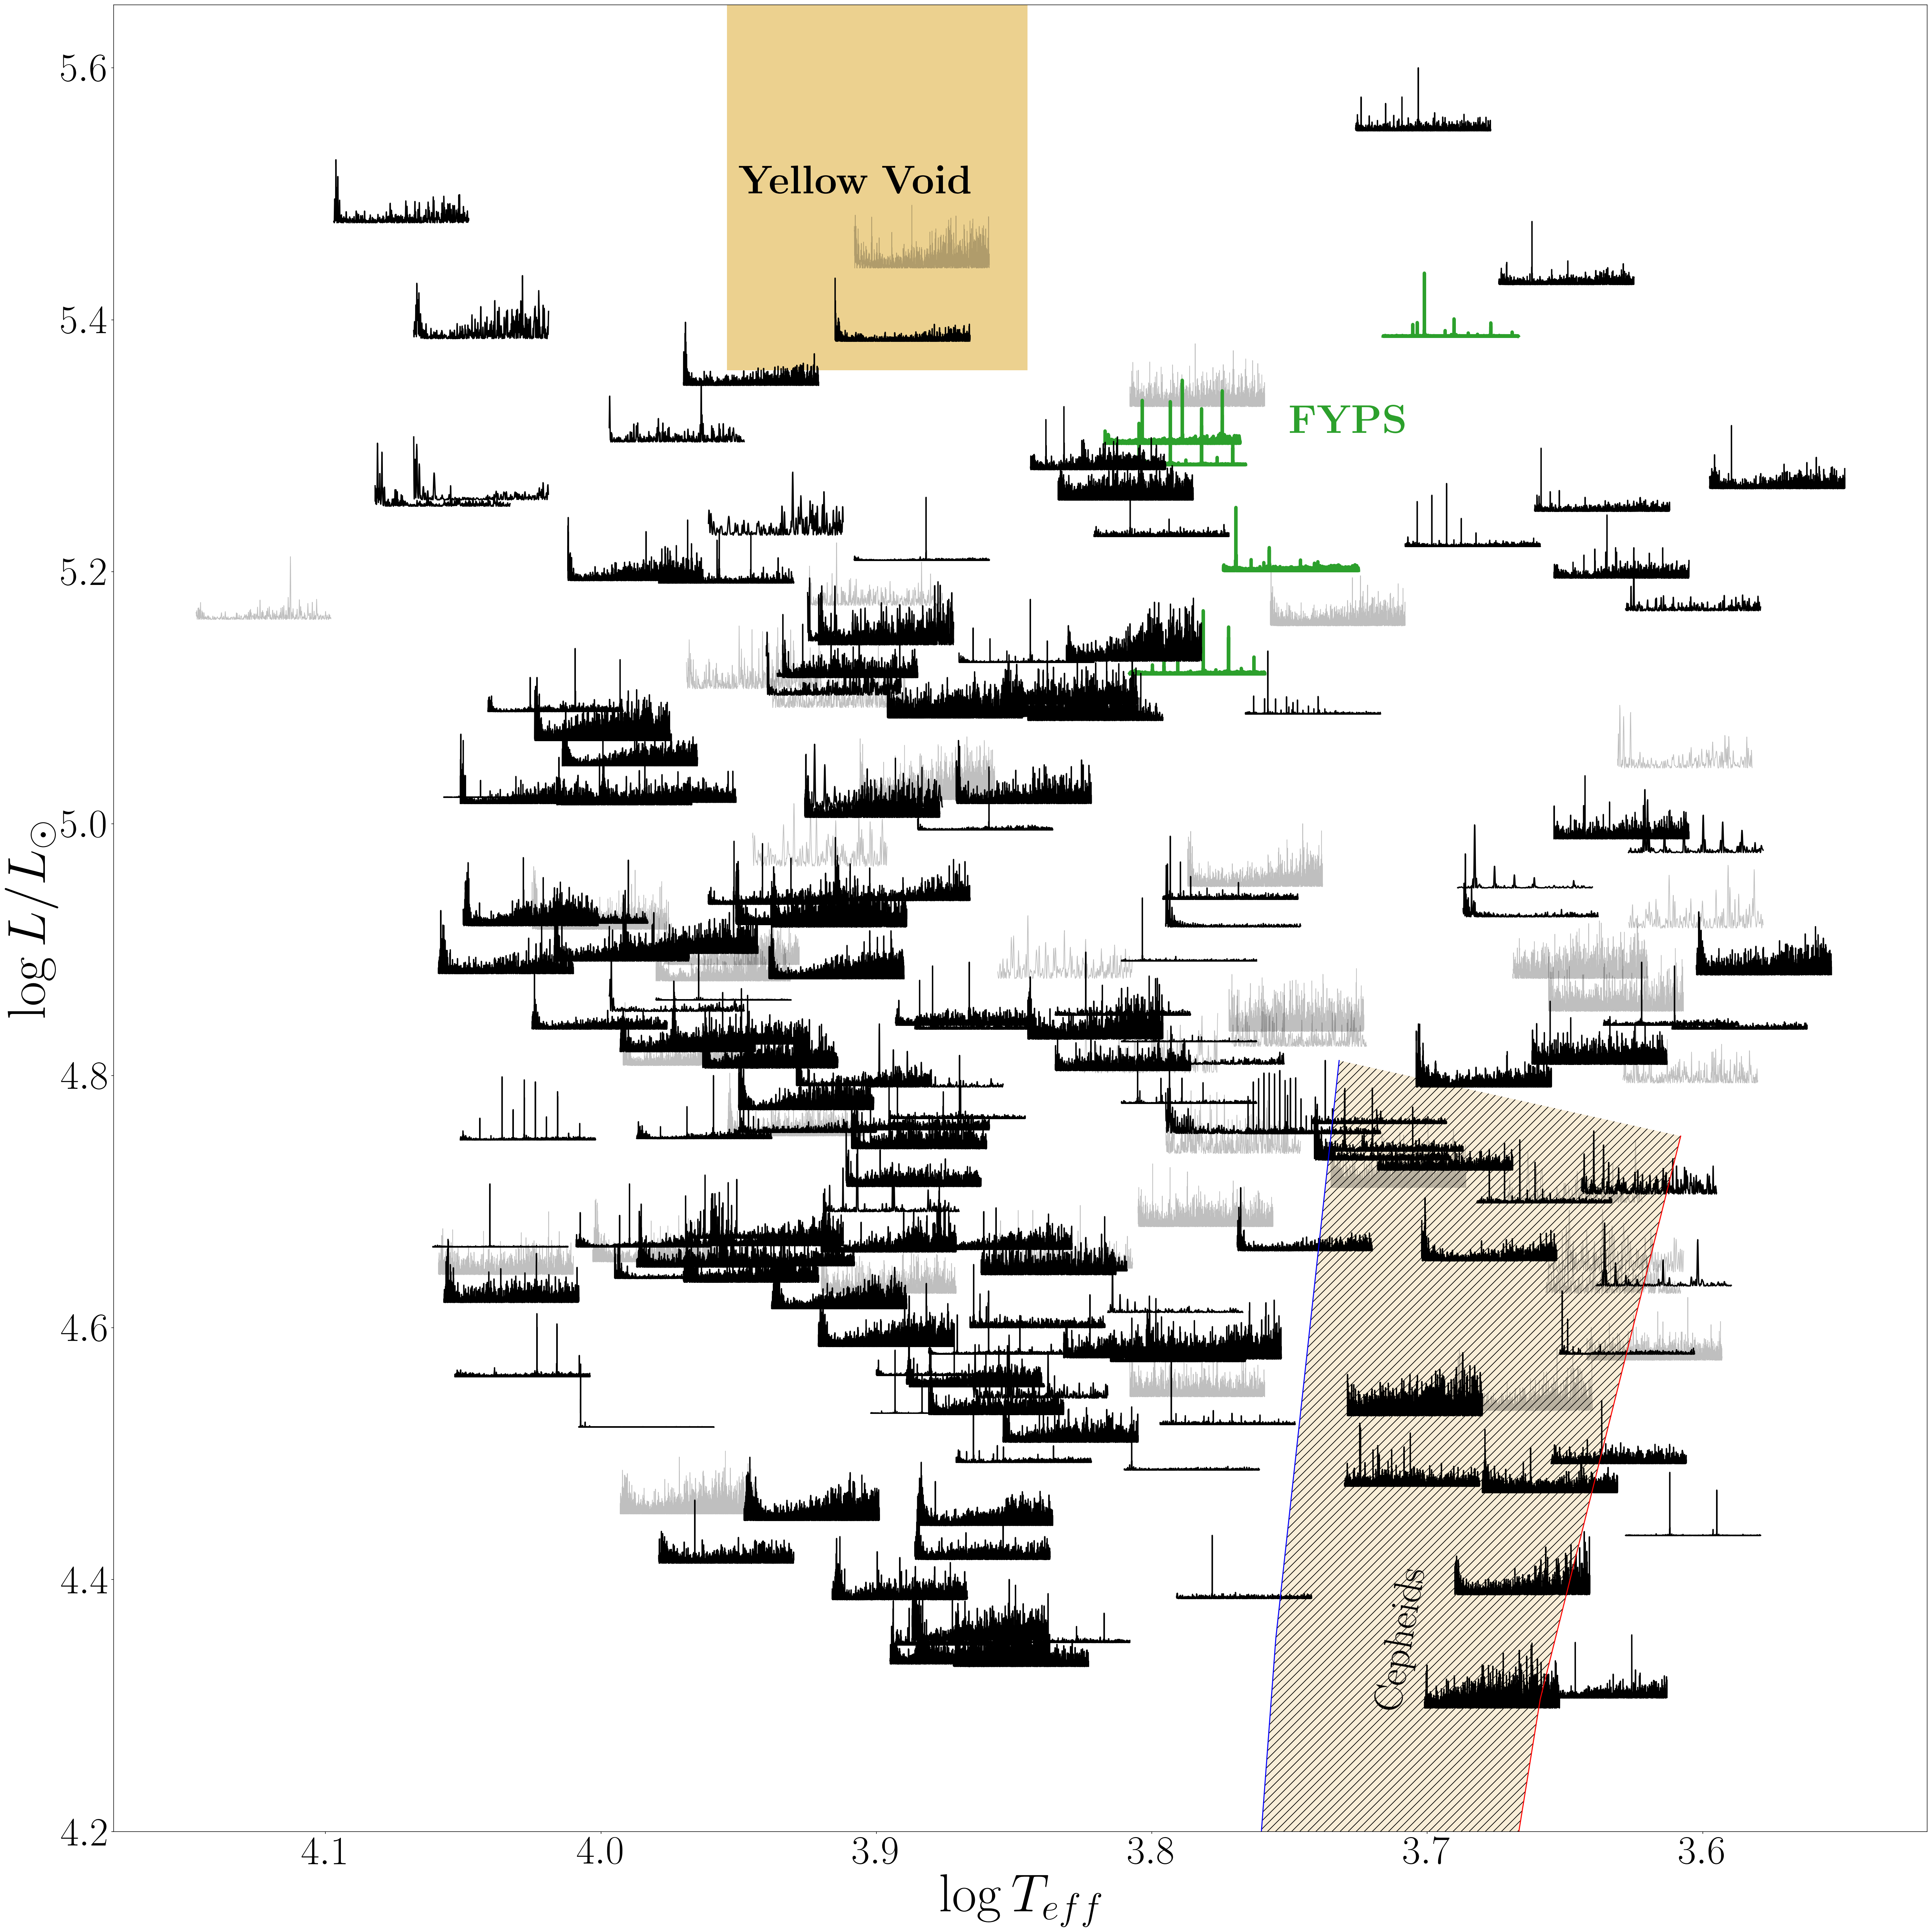

In [5]:
fig = plt.figure(figsize=(40,40),dpi=150)

from matplotlib import lines as mlines
from matplotlib.colors import Normalize
from scipy.stats import sigmaclip
import h5py as h5

fyps = pd.read_csv('paper_2020/fyps.csv')

#Plot RPS
i = 0
with h5.File('slfv_trimmed_resids.hdf5','r') as f:
    for tic,star in tqdm(merged.iterrows(), total=len(cool_sgs)):
        freq = f[f'{tic}/frequency'][()]
        resid = f[f'{tic}/residual_power'][()]
        if tic in fyps['TIC ID'].values:
            c = 'C2'
            lw=5
            alpha = 1
        elif star['n_peaks'] > 0: #/sigmaclip(resids[i],5,5)[0].std()
            c='k'
            alpha = 1
            lw=2
        else:
            c='k'
            alpha=0.25
            lw=1
        x = star['teff']
        y = star['lum']
        plt.plot(0.01*(-freq + 2.5) + x,0.05*(resid/resid.max()) - 0.05 + y,c=c,lw=lw,alpha=alpha,rasterized=True) #-f to handle axis flip
        #plt.scatter(x,y,c=c,alpha=alpha,rasterized=True,s=1000)
        i += 1

#Invert Axes and get xlimits
ax = plt.gca()
ax.invert_xaxis()
xl = ax.get_xlim()


#Plot Cepheid strip
ln1 = plt.plot(instability_strip['logTeff1'],instability_strip['logL1'],c='b')
ln2 = plt.plot(instability_strip['logTeff2'],instability_strip['logL2'],c='r')
inst_t = np.array([s['logTeff1'] for _,s in instability_strip.iterrows()])
inst_l = np.array([s['logL1'] for _,s in instability_strip.iterrows()])
for i,s in instability_strip.iterrows():
    if i == 0:
        inst_t = np.append(inst_t,s['logTeff2'])
        inst_l = np.append(inst_l,s['logL2'])
    else:
        inst_t = np.insert(inst_t,-1*i,s['logTeff2'])
        inst_l = np.insert(inst_l,-1*i,s['logL2'])
coords = np.hstack((inst_t[:,np.newaxis],inst_l[:,np.newaxis]))
poly = plt.Polygon(coords,fc='wheat',alpha=0.5,hatch='//')
ax.add_patch(poly)
plt.text(3.72,4.3,'Cepheids',fontdict={'fontsize':60},rotation=80)

#Plot Yellow Void, label alpha Cygnis
ylim = [4.2,5.65]
ymin = (5.36 - ylim[0])/(ylim[1]-ylim[0])

yv = plt.axvspan(xmin=np.log10(7000),xmax=np.log10(9000),ymin=ymin,fc='goldenrod',alpha=0.5)
#ac = plt.axvspan(xmin=4,xmax=4.1,ymin=0.325,ymax=0.675,fc='steelblue',alpha=0.5)
plt.text(3.95,5.5,r'$\mathrm{\bf Yellow\ Void}$',fontdict={'fontsize':60})
#plt.text(4.075,4.9,r'${\bf \alpha\ } \mathrm{\bf Cyg\ var.}$',fontdict={'fontsize':60,'color':'steelblue'})
plt.text(3.75,5.31,r'$\mathrm{\bf FYPS}$',fontdict={'fontsize':60,'color':'C2'})


ax.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$',ylim=ylim,xlim=xl)
ax.xaxis.label.set_size(80)
ax.yaxis.label.set_size(80)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(60)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(60)
    
plt.tight_layout()

In [217]:
# Now we're going to look for pulsators. First, grab stars where we can extract a frequency with >5 sigma

# Grab stars where we can extract a frequency with >5 sigma
pulse_detected = merged[(merged['n_peaks'] > 0) & (merged['highest_amp']/merged['highest_amp_error'] > 5)]
print(f"{len(pulse_detected)} stars with 5-sigma frequencies out of {len(merged)} total")

# We also used a GP to see if these frequencies were significant above the SLFV
gp_pulse = pd.read_csv('Find_FYPS_GP_results.csv', index_col=0)
pulse_detected_gp = pd.merge(pulse_detected, gp_pulse, left_index=True, right_index=True)
print(f"GP reveals {len(pulse_detected_gp[pulse_detected_gp['pulse_GP']==True])} true periodic stars")

# Load in info on which stars are consistent with RR Lyrae and Beta Cepheids...
likely_rrcep = pd.read_csv('likelyRRCep.csv',index_col=0)
likely_bcep = pd.read_csv('likelyBCep.csv',index_col=0)
contaminants = pd.merge(likely_rrcep,likely_bcep,left_index=True,right_index=True)

new = pd.merge(pulse_detected_gp,contaminants,left_index=True,right_index=True)
pulse_clean = new[(new['pulse_GP'])&(~new['LikelyRR'])&(~new['LikelyCep'])&(~new['LikelyBCep'])]
print(f"Filtering out contaminants leaves us with {len(pulse_clean)} stars")

155 stars with 5-sigma frequencies out of 201 total
GP reveals 154 true periodic stars
Filtering out contaminants leaves us with 111 stars


# Let's try a KDE to see where these pulsators are living

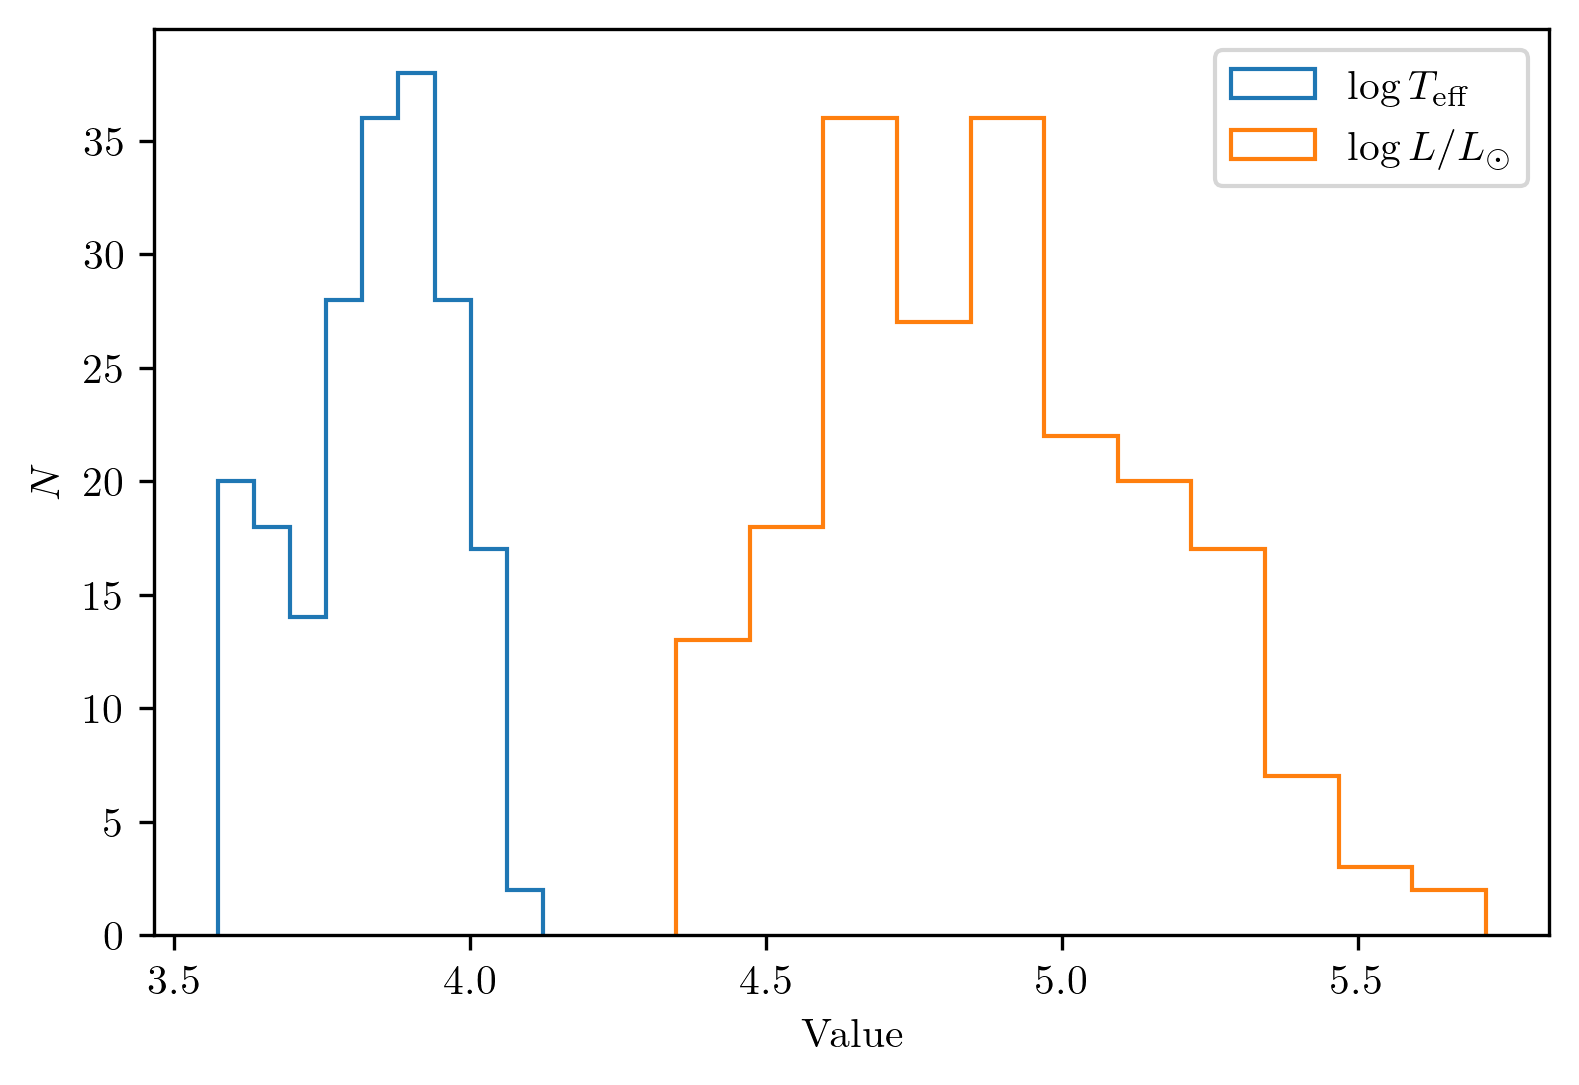

In [9]:
# First we need to scale our data so Teff and Lum have same statistics
fig = plt.figure(dpi=300)
plt.hist(merged['teff'],bins='auto',histtype='step',label=r'$\log T_{\rm eff}$')
plt.hist(merged['lum'],bins='auto',histtype='step',label=r'$\log L/L_\odot$');

plt.xlabel('Value')
plt.ylabel('$N$')
plt.legend()

In [39]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer

data_all = merged[['teff','lum']].values
data_pulse = pulse_clean[['teff','lum']].values

scaler = PowerTransformer() #RobustScaler() #StandardScaler()

data_all_trans = scaler.fit_transform(data_all)
data_pulse_trans = scaler.transform(data_pulse)

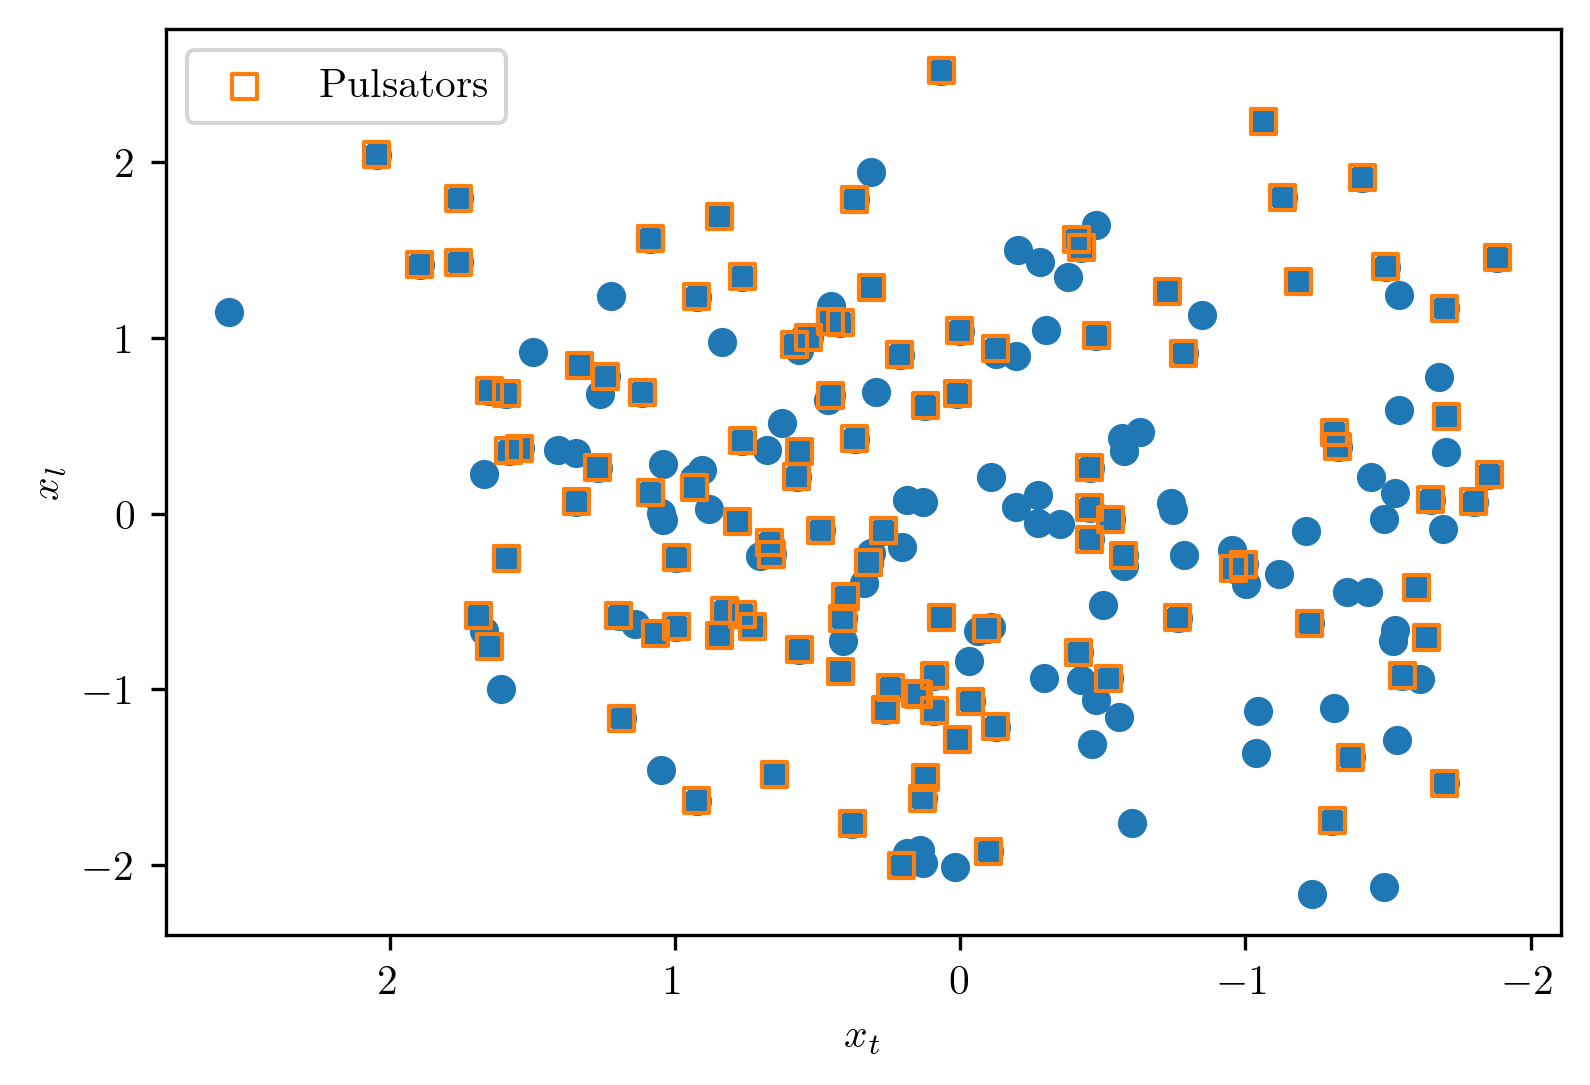

In [40]:
fig = plt.figure(dpi=300)
plt.scatter(data_all_trans[:,0],data_all_trans[:,1])
plt.scatter(data_pulse_trans[:,0],data_pulse_trans[:,1],marker='s',facecolor="None",edgecolor='C1',label='Pulsators')
plt.xlabel('$x_t$')
plt.gca().invert_xaxis()
plt.ylabel('$x_l$')
plt.legend()

In [138]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

params = {'bandwidth': np.arange(0.01,2,0.001)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data_all_trans)
    
KDE_bandwidth = 0.5#grid.best_estimator_.bandwidth
print(KDE_bandwidth)

kde_all = KernelDensity(bandwidth=KDE_bandwidth)
kde_all.fit(data_all_trans)

kde_pulse = KernelDensity(bandwidth=KDE_bandwidth)
kde_pulse.fit(data_pulse_trans)

X_trans, Y_trans = np.meshgrid(np.linspace(data_all_trans[:,0].min(),data_all_trans[:,0].max(),100), 
                   np.linspace(data_all_trans[:,1].min(),data_all_trans[:,1].max(),100))

xy_trans = np.vstack([X_trans.ravel(), Y_trans.ravel()]).T

#compute the KDE on a 100x100 grid of points
Z_all = np.exp(kde_all.score_samples(xy_trans)).reshape(X_trans.shape)
Z_pulse = np.exp(kde_pulse.score_samples(xy_trans)).reshape(X_trans.shape)

xy = scaler.inverse_transform(xy_trans).reshape(100,100,2)
X = xy[:,:,0]
Y = xy[:,:,1]

0.5


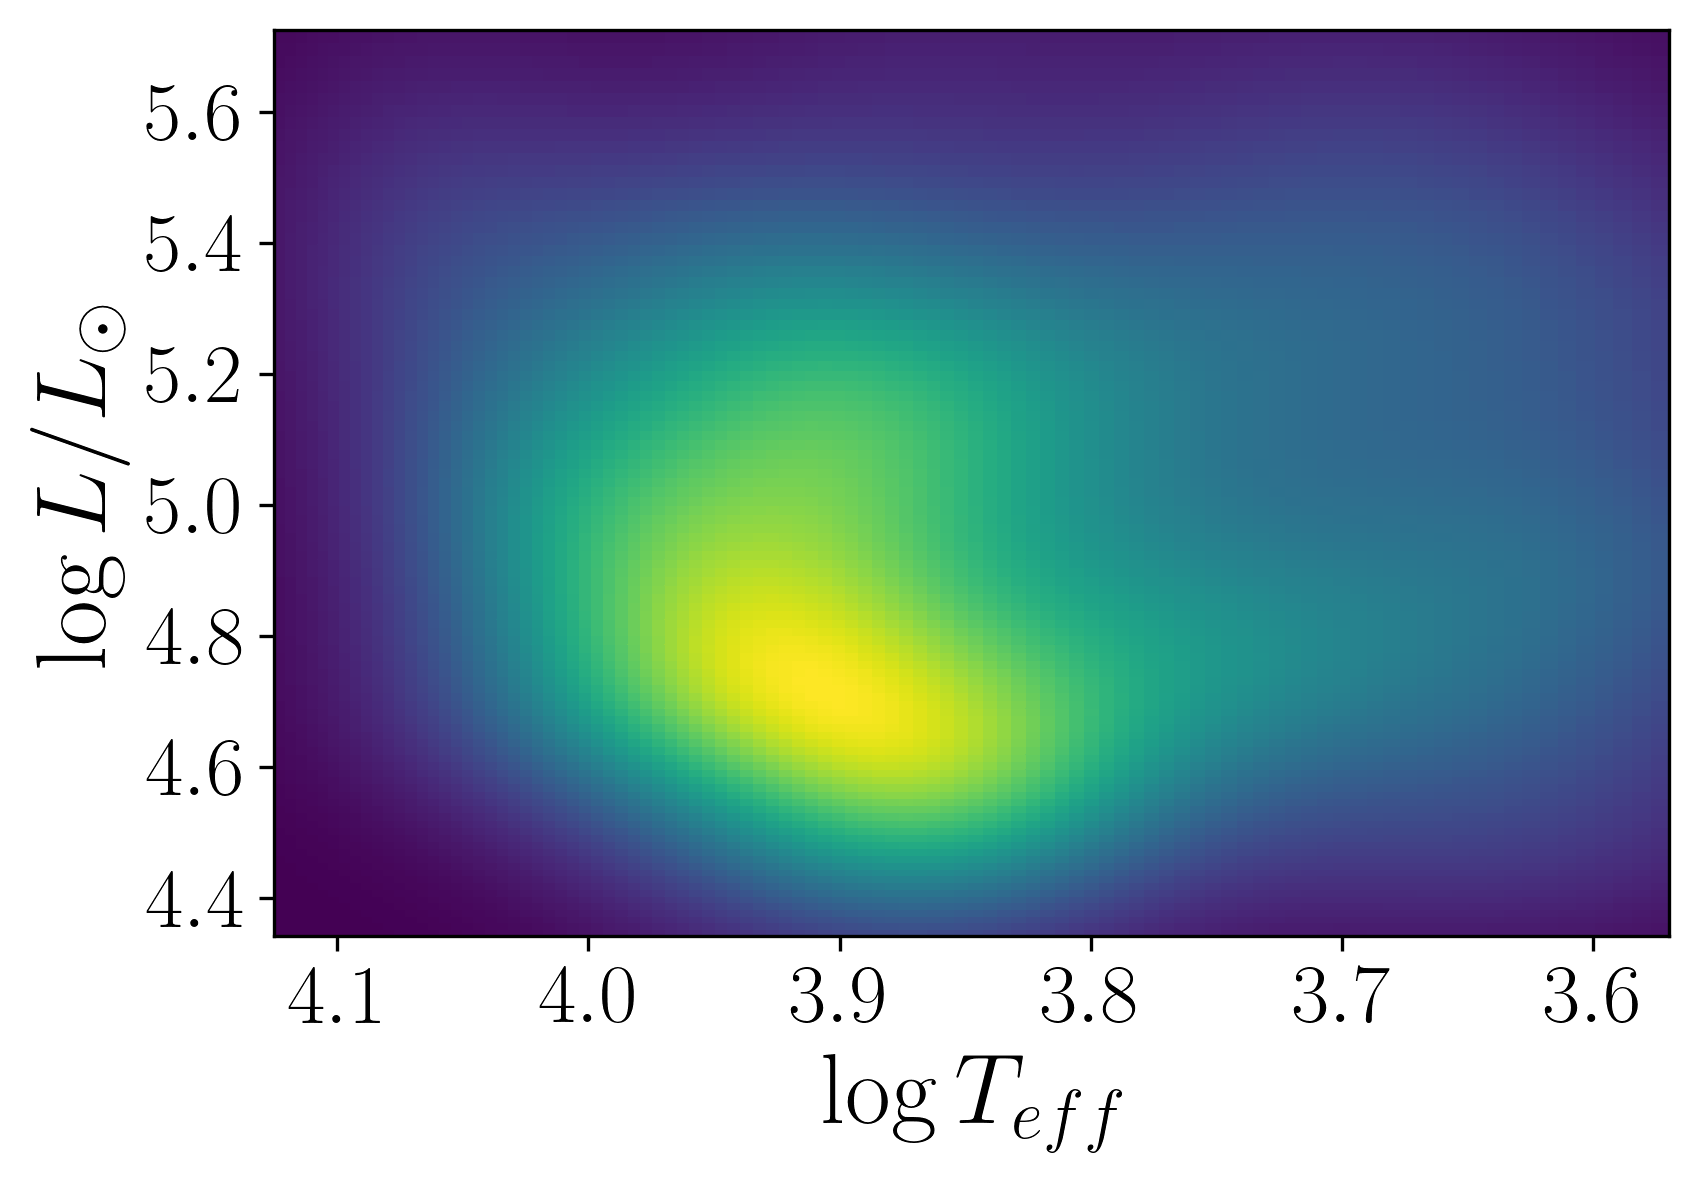

In [139]:
fig = plt.figure(dpi=300)

mp = plt.pcolormesh(X,Y,Z_pulse,shading='nearest')

ax = plt.gca()
ax.invert_xaxis()


ax.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$')

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.savefig('../plots/kde_pulse.pdf',bbox_inches='tight')

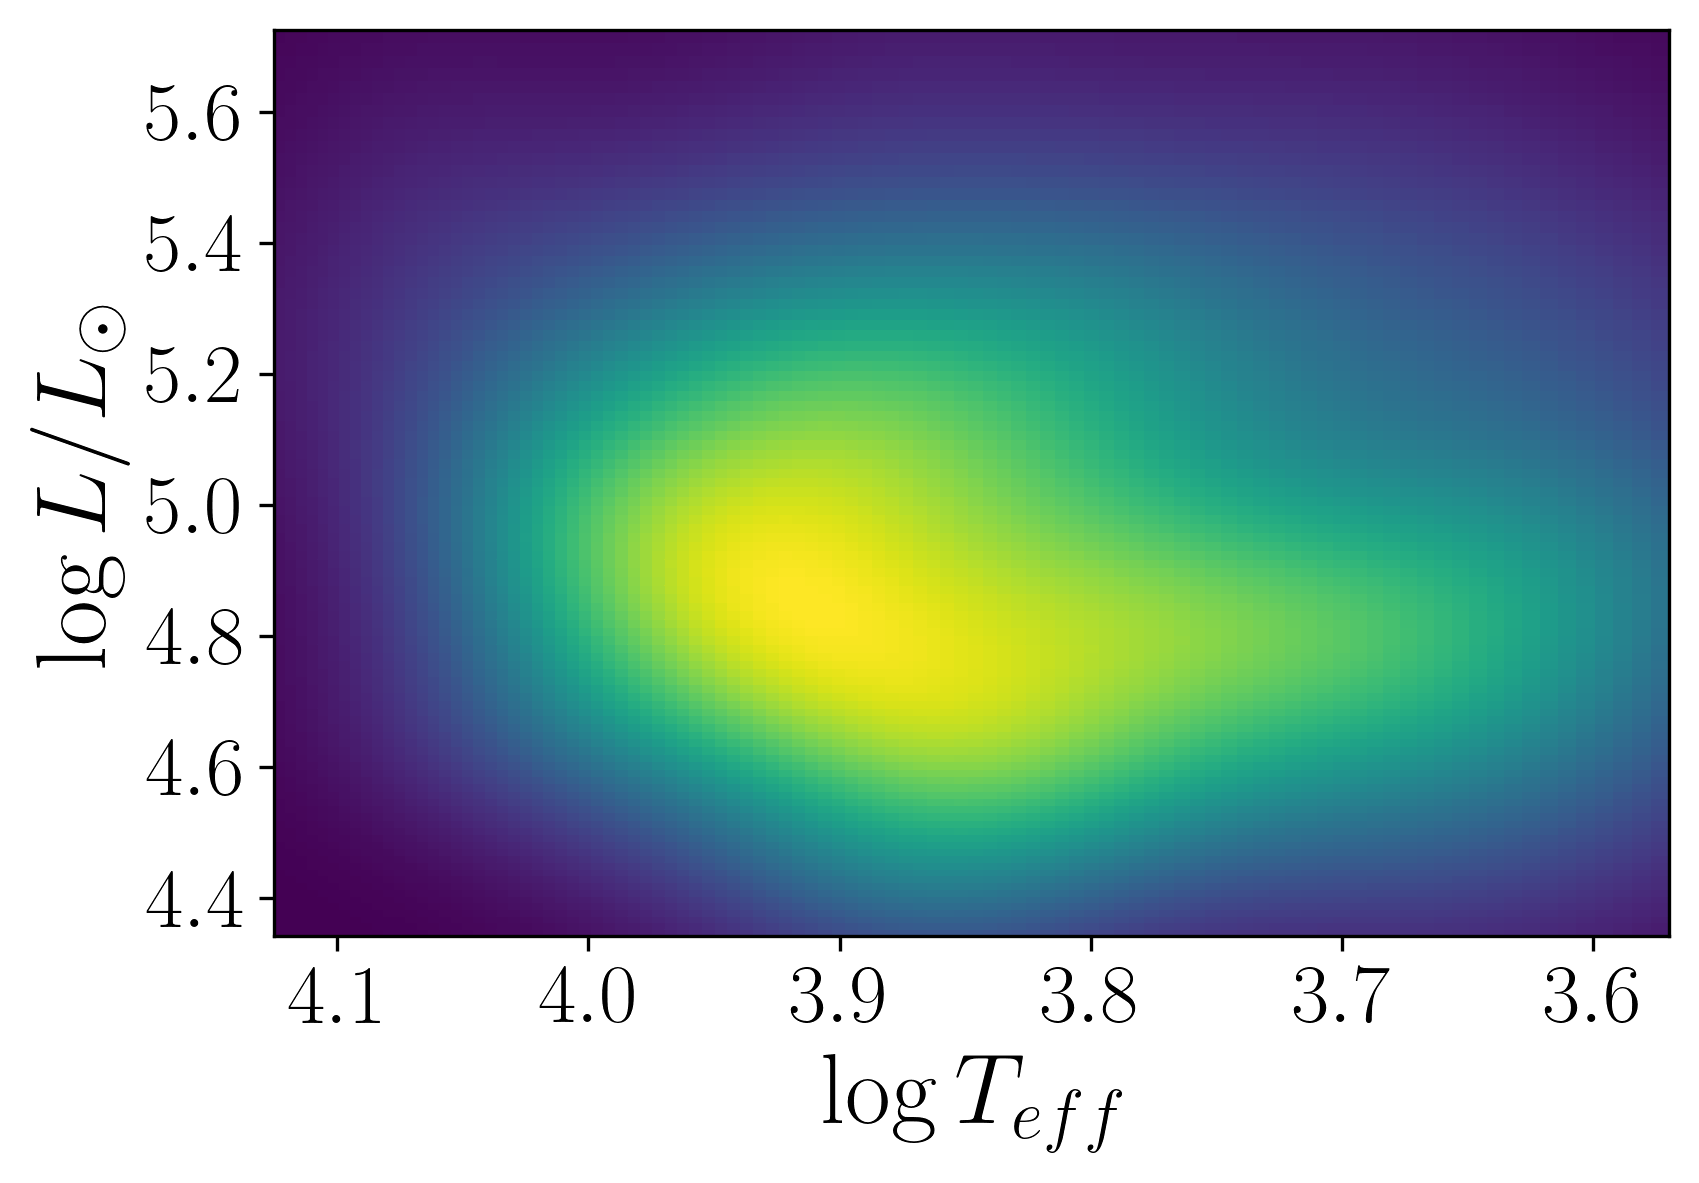

In [141]:
fig = plt.figure(dpi=300)

mp = plt.pcolormesh(X,Y,Z_all,shading='nearest')

ax = plt.gca()
ax.invert_xaxis()

ax.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$')

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.savefig('../plots/kde_all.pdf',bbox_inches='tight')

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The following kwargs were not used by contour: 'shading'
  This is separate from the ipykernel package so we can avoid doing imports until


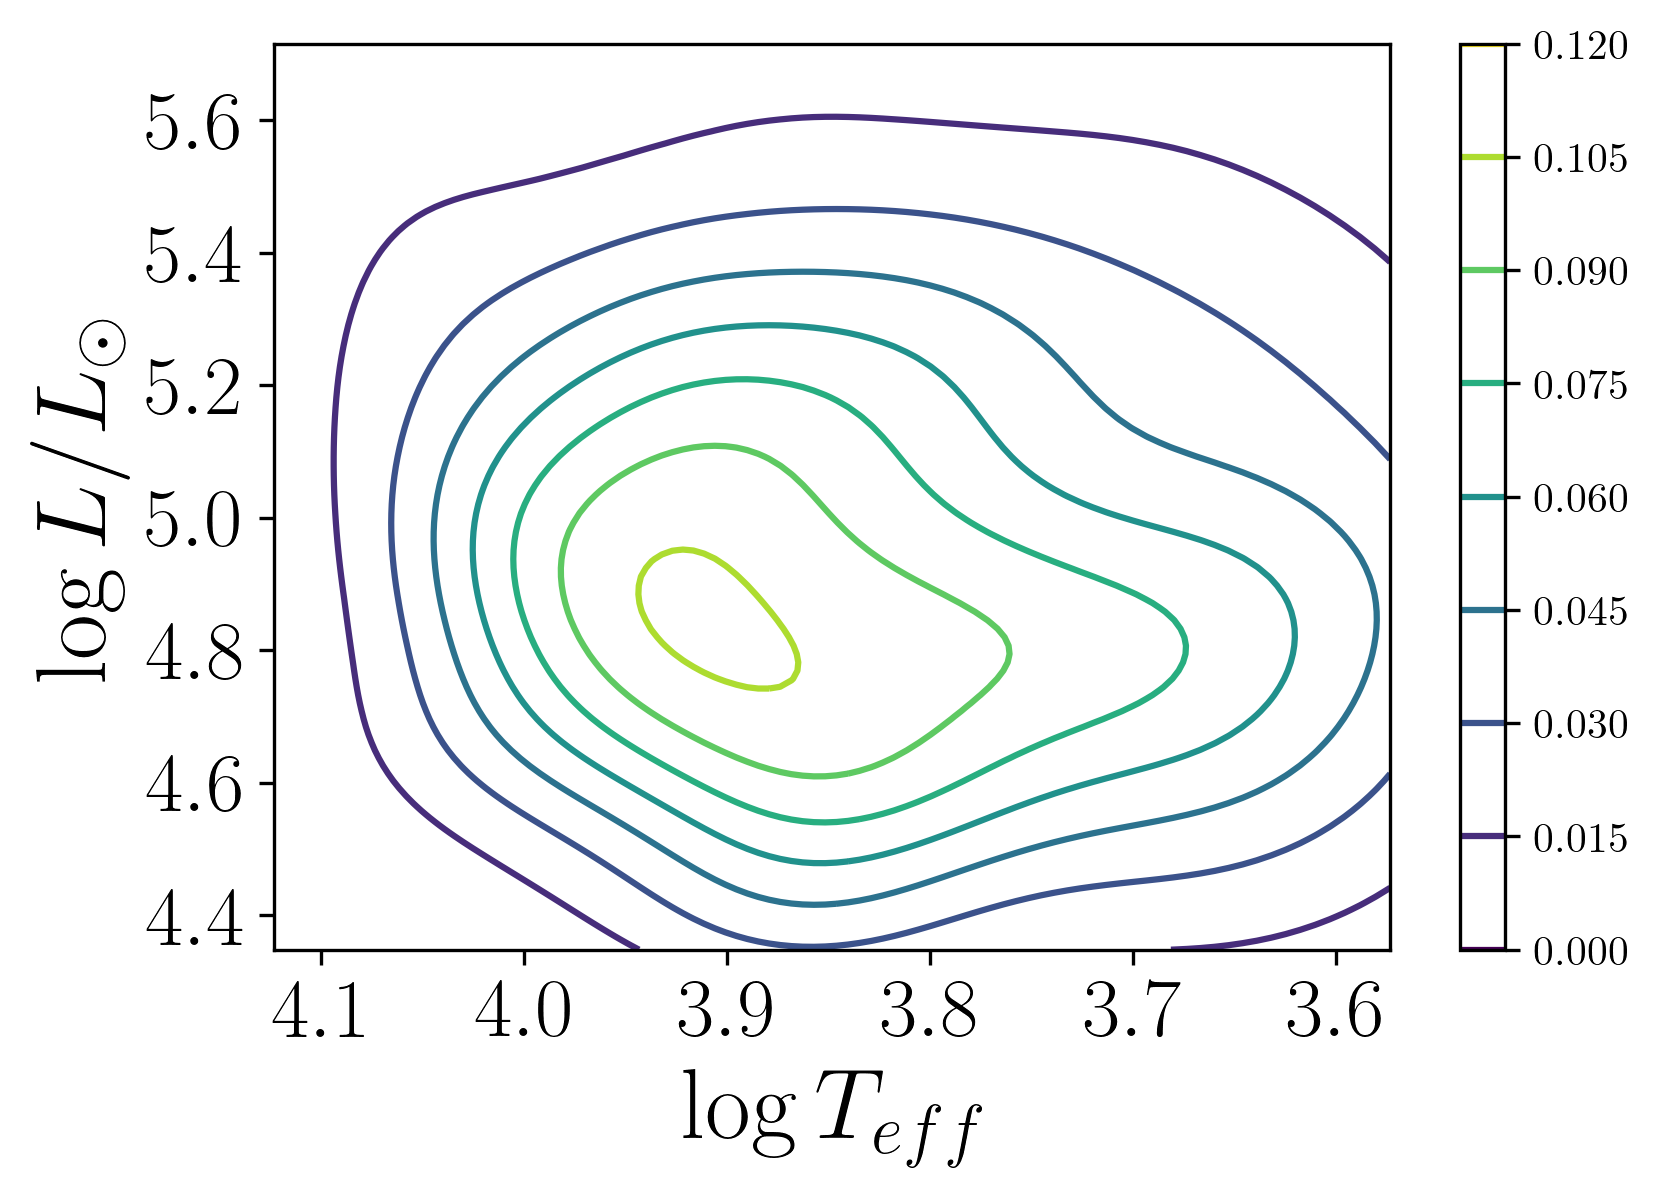

In [142]:
fig = plt.figure(dpi=300)

cl = plt.contour(X,Y,Z_all,shading='nearest')

ax = plt.gca()
ax.invert_xaxis()

ax.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$')

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
plt.colorbar(cl)
#plt.savefig('../plots/kde_all.pdf',bbox_inches='tight')

In [147]:
cl.levels

array([0.   , 0.015, 0.03 , 0.045, 0.06 , 0.075, 0.09 , 0.105, 0.12 ])

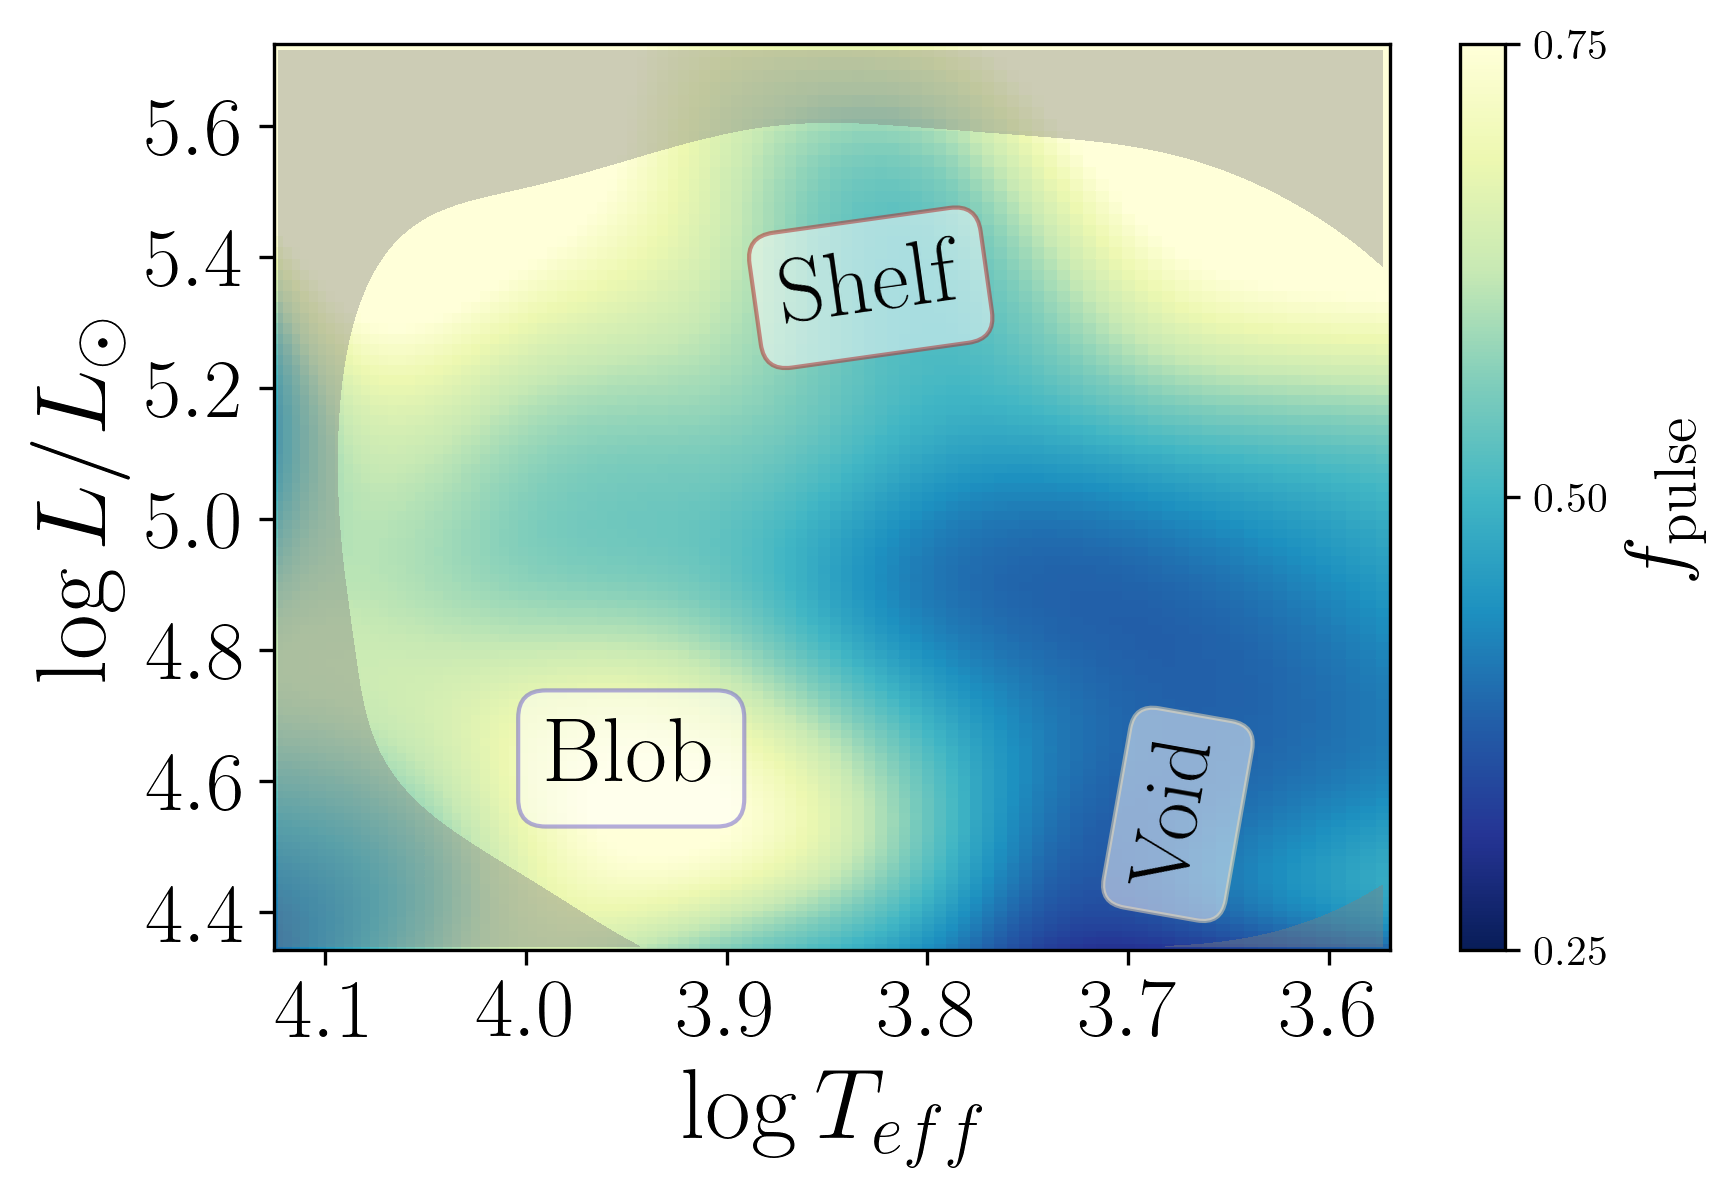

In [148]:
fig = plt.figure(dpi=300)
instability_strip = pd.read_table('paper_2020/instability_strip.txt',sep=' ',index_col=False)
fyps = pd.read_csv('paper_2020/fyps.csv')
#instability strip from Geneva models, Anderson et al. (2016) for omega_i = 0, Z=0.006

mp = plt.pcolormesh(X,Y,(Z_pulse/Z_all) * (len(pulse_clean)/len(merged)),vmin=0.25,vmax=0.75,shading='nearest',cmap='YlGnBu_r')
cb = plt.colorbar(mp)
cb.set_label(r'$f_{\rm pulse}$',fontsize=20)
cb.set_ticks([0.25,0.5,0.75])

#plt.contourf(X,Y,(Z_pulse/Z_all) * (len(pulse_clean)/len(merged)),levels=[0.75,1e10],colors='grey',alpha=0.4,zorder=5)
plt.contourf(X,Y,Z_all,levels=[0,cl.levels[1]],colors='grey',alpha=0.4,zorder=5)
ax = plt.gca()
ax.invert_xaxis()

plt.text(3.875,5.3,'Shelf',c='k',fontdict={'fontsize':22},rotation=8,
        bbox=dict(boxstyle="round",
                   ec='firebrick',
                   fc='w',
                   alpha=0.5
                   ))
plt.text(3.99,4.6,r'Blob',c='k',fontdict={'fontsize':22},rotation=0,
        bbox=dict(boxstyle="round",
                   ec='slateblue',
                   fc='w',
                   alpha=0.5))
plt.text(3.7,4.45,'Void',fontdict={'fontsize':20},rotation=80,
        bbox=dict(boxstyle="round",
                   ec='wheat',
                   fc='w',
                   alpha=0.5
                   ))

ax.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$')

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.savefig('../plots/kde_hr_nobox.pdf',bbox_inches='tight')

In [149]:
import math

def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

nCr(len(merged),len(pulse_clean)),len(merged),len(pulse_clean)

(6.052130497201947e+58, 201, 111)

So we can't directly simulate all 10^58 possible outcomes, but we can do a sampling...

In [153]:
N_trials = 10000
f_stack = np.empty((N_trials,*Z_pulse.shape))

true_ratio = Z_pulse/Z_all * (len(pulse_clean)/len(merged))
random_state = np.random.RandomState(seed=42)
for i in tqdm(range(N_trials)):
    random_sample = merged.sample(n=len(pulse_clean),replace=False,random_state=random_state)
    
    data_trial = scaler.transform(random_sample[['teff','lum']].values)
    kde_trial = KernelDensity(bandwidth=KDE_bandwidth)
    kde_trial.fit(data_trial)

    #compute the KDE on a 100x100 grid of points
    Z_trial = np.exp(kde_trial.score_samples(xy_trans)).reshape(X_trans.shape)
    f_stack[i] = Z_trial/Z_all * (len(pulse_clean)/len(merged))

good = true_ratio > f_stack
f_gtr = good.sum(axis=0)/N_trials

  0%|          | 0/10000 [00:00<?, ?it/s]

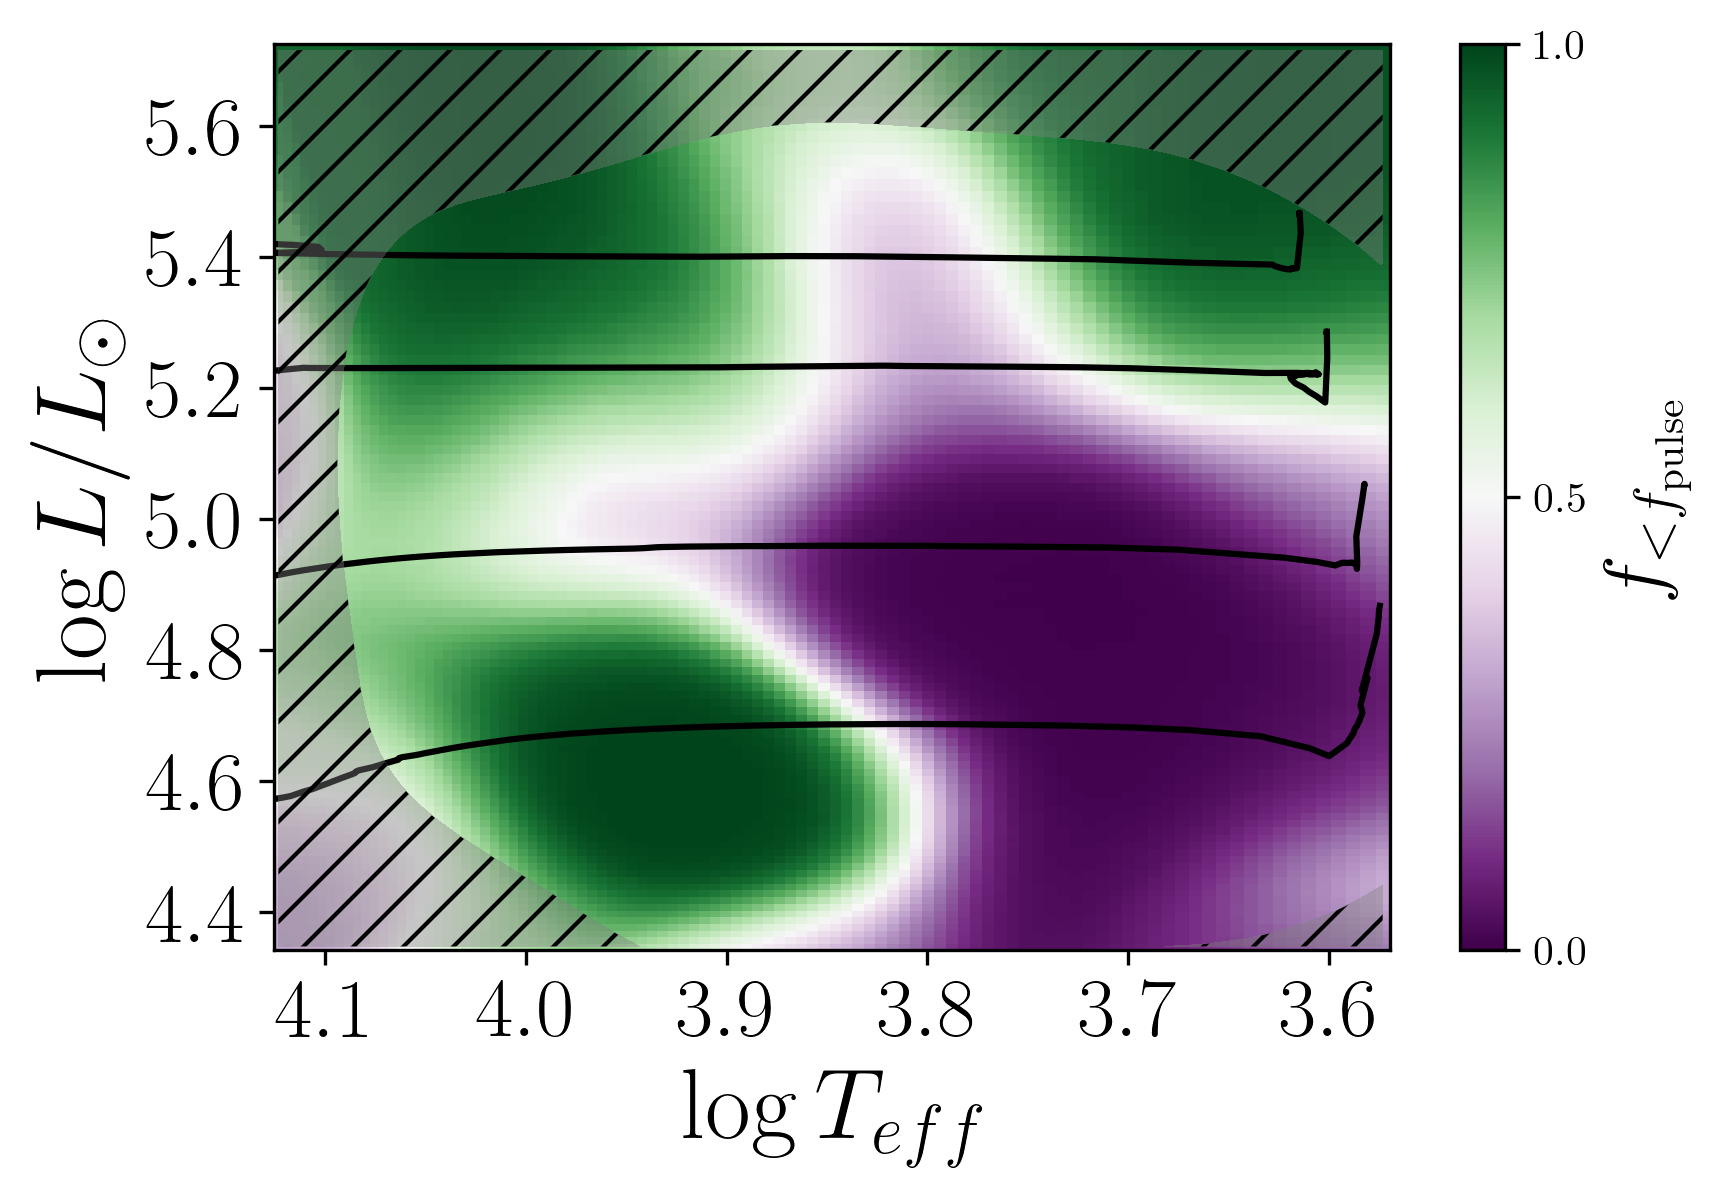

In [154]:
fig = plt.figure(dpi=300)
mp = plt.pcolormesh(X,Y,f_gtr,vmin=0,vmax=1,shading='nearest',cmap='PRGn')

cb = plt.colorbar(mp)
cb.set_label(r'$f_{<f_{\rm pulse}}$',fontsize=20)
cb.set_ticks([0,0.5,1.0])

#plt.contourf(X,Y,(Z_pulse/Z_all) * (len(pulse_clean)/len(merged)),levels=[0.75,1e10],colors='grey',alpha=0.4,zorder=5,hatches=['//'])
plt.contourf(X,Y,Z_all,levels=[0,cl.levels[1]],colors='grey',alpha=0.4,zorder=5,hatches=['//'])
ax = plt.gca()
ax.invert_xaxis()
xl = ax.get_xlim()
yl = ax.get_ylim()

geneva_dir = '../data/Geneva/'
masses = [12,15,20,25]
for m in masses:
    g = pd.read_table(f'../data/Geneva/M{str(m).zfill(3)}p00Z06V40.dat',skiprows=2,names=['line','time','mass','lg(L)','lg(Teff)','1H_surf','4He_surf','12C_surf','13C_surf','14N_surf','16O_surf','17O_surf','18O_surf','20Ne_surf','22Ne_surf','26Al_surf','Mcc/Mt','lg(Teff)_x','lg(Md)','lg(rhoc)','lg(Tc)','1H_cen','4He_cen','12C_cen','13C_cen','14N_cen','16O_cen','17O_cen','18O_cen','20Ne_cen','22Ne_cen','26Al_cen','Omeg_surf','Omeg_cen','Rp/Req ','Md/Md(0)','v_crit1','v_crit2','v_equa','Om/Om_cr','Gamma_Ed','lg(Mdot_mech)','L_tot'],
            index_col='line',delim_whitespace=True)
    ax.plot(g['lg(Teff)'],g['lg(L)'],c='k')


ax.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$',xlim=xl,ylim=yl)

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
plt.savefig('../plots/kde_bootstrap_no_annotate.pdf',bbox_inches='tight')

In [222]:
def fyps_box(df):
    """
    Returns part of dataframe where teff and lum are in the FYPS box
    """
    
    #tmin = df['teff'] >= 3.6
    #tmax = df['teff'] <= 4.1
    #lmax = df['lum'] <= 7.76 - 0.6*df['teff']
    lmin = df['lum'] >= 5.0 #6.23 - 0.3*df['teff']
    
    return lmin # & lmax & tmin & tmax

candidate_fyps = pulse_clean[fyps_box(pulse_clean)]
all_in_box = merged[fyps_box(merged)]
len(candidate_fyps), len(all_in_box), len(candidate_fyps)/len(all_in_box)

(39, 63, 0.6190476190476191)

In [158]:
fyps[['CommonName','TIC ID','teff','lum']]

CommonName     TIC ID   teff    lum
0  HD 269953  404850274  3.692  5.437
1  HD 269110   40404470  3.750  5.251
2  HD 268687   29984014  3.784  5.169
3  HD 269840  277108449  3.791  5.335
4  HD 269902  277300045  3.793  5.352

In [159]:
fyps.columns

Index(['CommonName', 'ContRatio', 'Dec', 'Dec_y', 'MKType', 'MatchID', 'RA',
       'RA_y', 'SimbadOType', 'SimbadSpT', 'SpT', 'SpecSource', 'TIC ID',
       'Tmag', 'dist', 'lum', 'pmDec', 'pmRA', 'teff', 'w1mag', 'w2mag',
       'w3mag', 'w4mag', 'alpha', 'e_alpha', 'tau', 'e_tau', 'gamma',
       'e_gamma', 'alpha_w', 'e_alpha_w'],
      dtype='object')

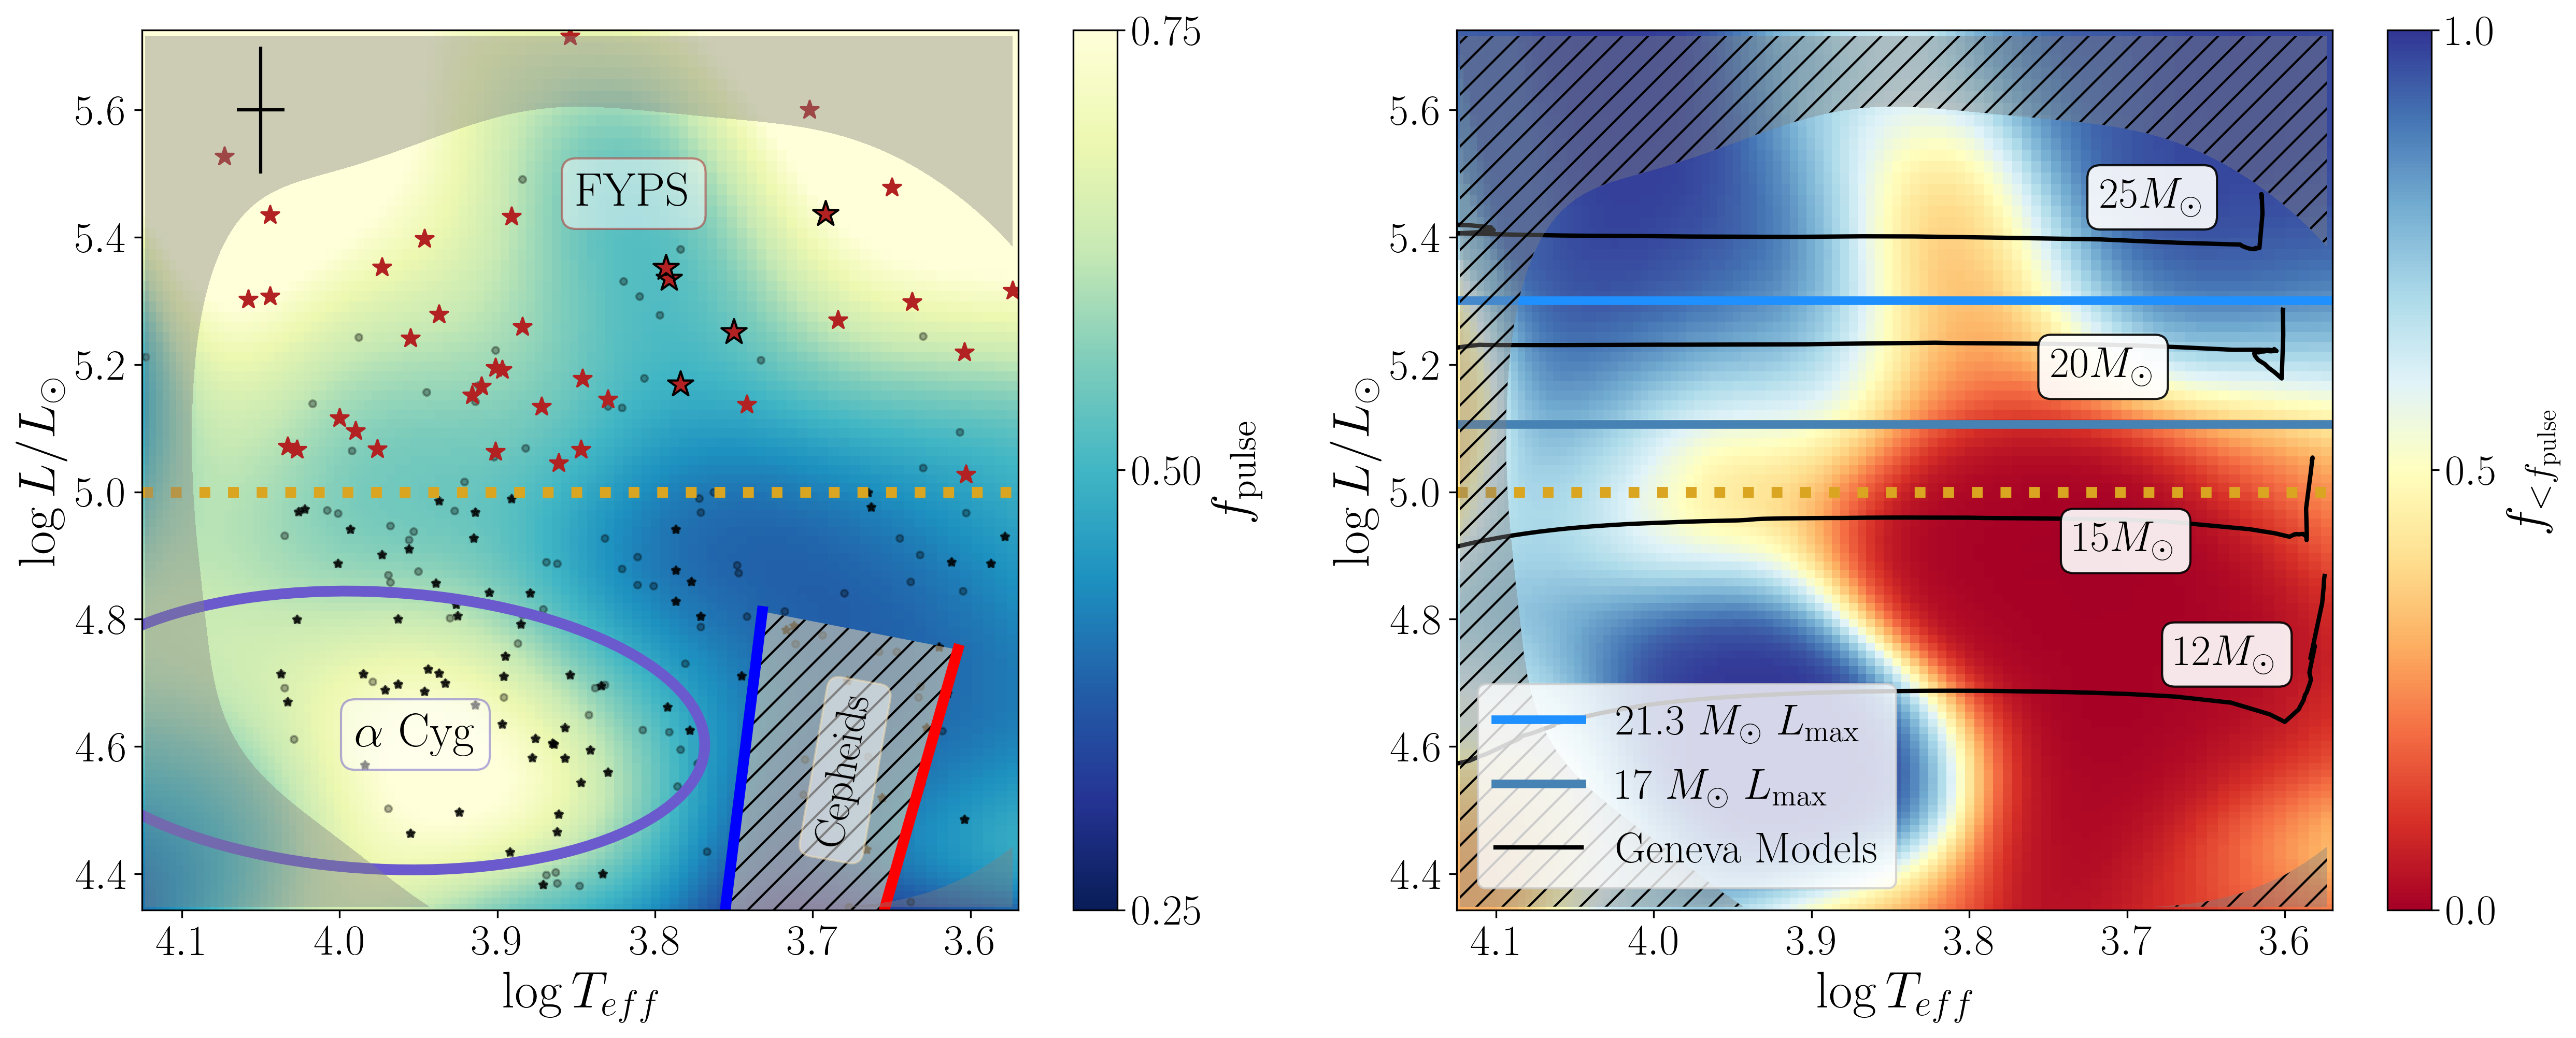

In [350]:
fig, ax = plt.subplots(1,2,figsize=(2*60/6,7.5),dpi=300)

# f_pulse in this axis

mp = ax[0].pcolormesh(X,Y,(Z_pulse/Z_all) * (len(pulse_clean)/len(merged)),vmin=0.25,vmax=0.75,shading='nearest',cmap='YlGnBu_r')
cb = plt.colorbar(mp,ax=ax[0])
cb.set_label(r'$f_{\rm pulse}$',fontsize=24)
cb.set_ticks([0.25,0.5,0.75])
cb.ax.tick_params(labelsize=20)

#plt.contourf(X,Y,(Z_pulse/Z_all) * (len(pulse_clean)/len(merged)),levels=[0.75,1e10],colors='grey',alpha=0.4,zorder=5)
ax[0].contourf(X,Y,Z_all,levels=[0,cl.levels[1]],colors='grey',alpha=0.4,zorder=5)
ax[0].invert_xaxis()
xl = ax[0].get_xlim()
yl = ax[0].get_ylim()

ax[0].scatter(merged['teff'],merged['lum'],c='k',alpha=0.3,s=10)
ax[0].scatter(pulse_clean['teff'],pulse_clean['lum'],c='k',marker='*',alpha=0.7,s=15)
ax[0].scatter(candidate_fyps['teff'],candidate_fyps['lum'],c='firebrick',marker='*',s=75)
ax[0].scatter(fyps['teff'],fyps['lum'],c='firebrick',marker='*',edgecolor='k',s=150)


#ax[0].text(3.925,5.3,'FYPS',c='k',fontdict={'fontsize':22},rotation=12,
ax[0].text(3.85,5.45,'FYPS',c='k',fontdict={'fontsize':22},rotation=0,
        bbox=dict(boxstyle="round",
                   ec='firebrick',
                   fc='w',
                   alpha=0.5
                   ))

#ax[0].plot([4.1,3.6],[5.0,5.15],ls='--',lw=5,c='firebrick',zorder=1) #bottom
#ax[0].plot([4.1,3.6],[5.3,5.6],ls='--',lw=5,c='firebrick',zorder=1) #top
#ax[0].plot([4.1,4.1],[5.0,5.3],ls='--',lw=5,c='firebrick',zorder=1) #hot
#ax[0].plot([3.6,3.6],[5.15,5.6],ls='--',lw=5,c='firebrick',zorder=1) #cool
ax[0].axhline(5.0,c='goldenrod',ls=':',lw=5)



from matplotlib.patches import Ellipse
ax[0].text(3.99,4.6,r'$\alpha$ Cyg',c='k',fontdict={'fontsize':22},rotation=0,
        bbox=dict(boxstyle="round",
                   ec='slateblue',
                   fc='w',
                   alpha=0.5))

cx = 3.975
cy = 4.625
a_x = 0.4
a_y = 0.45
theta = -30
num1 = np.power(np.cos(np.deg2rad(theta))*(pulse_clean['teff']-cx) + np.sin(np.deg2rad(theta))*(pulse_clean['lum']-cy), 2.0)
den1 = (a_x/2.0) ** 2.0
num2 = np.power(np.sin(np.deg2rad(theta))*(pulse_clean['teff']-cx) - np.cos(np.deg2rad(theta))*(pulse_clean['lum']-cy), 2.0)
den2 = (a_y/2.0) ** 2.0
in_ellipse = pulse_clean[num1/den1 + num2/den2 <= 1.0]
#ax[0].scatter(in_ellipse['teff'],in_ellipse['lum'],c='grey',marker='*')
ax[0].add_patch(Ellipse((cx, cy), a_x, a_y, angle=theta, fill=False,edgecolor='slateblue',lw=5))



#Plot Cepheid strip
ln1 = ax[0].plot(instability_strip['logTeff1'],instability_strip['logL1'],lw=5,c='b')
ln2 = ax[0].plot(instability_strip['logTeff2'],instability_strip['logL2'],lw=5,c='r')
inst_t = np.array([s['logTeff1'] for _,s in instability_strip.iterrows()])
inst_l = np.array([s['logL1'] for _,s in instability_strip.iterrows()])
for i,s in instability_strip.iterrows():
    if i == 0:
        inst_t = np.append(inst_t,s['logTeff2'])
        inst_l = np.append(inst_l,s['logL2'])
    else:
        inst_t = np.insert(inst_t,-1*i,s['logTeff2'])
        inst_l = np.insert(inst_l,-1*i,s['logL2'])
coords = np.hstack((inst_t[:,np.newaxis],inst_l[:,np.newaxis]))
poly = plt.Polygon(coords,fc='wheat',alpha=0.5,hatch='//')
ax[0].add_patch(poly)
ax[0].text(3.7,4.45,'Cepheids',fontdict={'fontsize':20},rotation=80,
        bbox=dict(boxstyle="round",
                   ec='wheat',
                   fc='w',
                   alpha=0.5
                   ))

ax[0].errorbar(4.05,5.6,xerr=0.015,yerr=0.1,zorder=10,c='k')


ax[0].set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$',xlim=xl,ylim=yl)

ax[0].xaxis.label.set_size(24)
ax[0].yaxis.label.set_size(24)
for tick in ax[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(20)


# Bootstrap test in this axis

mp = ax[1].pcolormesh(X,Y,f_gtr,vmin=0,vmax=1,shading='nearest',cmap='RdYlBu')

cb = plt.colorbar(mp)
cb.set_label(r'$f_{<f_{\rm pulse}}$',fontsize=24)
cb.set_ticks([0,0.5,1.0])
cb.ax.tick_params(labelsize=20)

#plt.contourf(X,Y,(Z_pulse/Z_all) * (len(pulse_clean)/len(merged)),levels=[0.75,1e10],colors='grey',alpha=0.4,zorder=5,hatches=['//'])
ax[1].contourf(X,Y,Z_all,levels=[0,cl.levels[1]],colors='grey',alpha=0.4,zorder=5,hatches=['//'])
ax[1].invert_xaxis()
xl = ax[1].get_xlim()
yl = ax[1].get_ylim()

#ax[1].text(3.85,5.45,'FYPS',c='k',fontdict={'fontsize':22},rotation=0,
#        bbox=dict(boxstyle="round",
#                   ec='firebrick',
#                   fc='w',
#                   alpha=0.9
#                   ))


#ax[1].plot([4.1,3.6],[5.0,5.15],ls='--',lw=5,c='firebrick',zorder=1) #bottom
#ax[1].plot([4.1,3.6],[5.3,5.6],ls='--',lw=5,c='firebrick',zorder=1) #top
#ax[1].plot([4.1,4.1],[5.0,5.3],ls='--',lw=5,c='firebrick',zorder=1) #hot
#ax[1].plot([3.6,3.6],[5.15,5.6],ls='--',lw=5,c='firebrick',zorder=1) #cool
ax[1].axhline(5.0,c='goldenrod',ls=':',lw=5)


def Mi_to_L(M):
    """
    Computes Eq (2) of Kochanek (2020) to convert between an initial mass and final luminosity
    Derived from Sukhbold+(2018) models
    """
    term1 = 4.610
    term2 = 2.267*np.log10(M/10.0)
    term3 = -0.494*((np.log10(M/10.0)) ** 2.0)
    return term1 + term2 + term3

L_max = Mi_to_L(21.3) # from Table 1, Kochanek (2020)
ax[1].axhline(y=L_max,c='dodgerblue',lw=4,label=r'21.3 $M_\odot$ $L_{\rm max}$')
ax[1].axhline(y=Mi_to_L(17.0),c='steelblue',lw=4,label=r'17 $M_\odot$ $L_{\rm max}$') #and 17 Msun

geneva_dir = '../data/Geneva/'
masses = [12,15,20,25]
g_text = 3.65
for i,m in enumerate(masses):
    t_offset = 0.0
    l_offset = 0.05
    label = None
    if i == 0:
        label = 'Geneva Models'
    if m == 15:
        t_offset = 0.025
        l_offset = -0.05
    if m == 20:
        t_offset = 0.05
        l_offset = -0.05
    g = pd.read_table(f'../data/Geneva/M{str(m).zfill(3)}p00Z06V40.dat',skiprows=2,names=['line','time','mass','lg(L)','lg(Teff)','1H_surf','4He_surf','12C_surf','13C_surf','14N_surf','16O_surf','17O_surf','18O_surf','20Ne_surf','22Ne_surf','26Al_surf','Mcc/Mt','lg(Teff)_x','lg(Md)','lg(rhoc)','lg(Tc)','1H_cen','4He_cen','12C_cen','13C_cen','14N_cen','16O_cen','17O_cen','18O_cen','20Ne_cen','22Ne_cen','26Al_cen','Omeg_surf','Omeg_cen','Rp/Req ','Md/Md(0)','v_crit1','v_crit2','v_equa','Om/Om_cr','Gamma_Ed','lg(Mdot_mech)','L_tot'],
            index_col='line',delim_whitespace=True)
    ax[1].plot(g['lg(Teff)'],g['lg(L)'],c='k',lw=2,label=label)
    g_loc = g.loc[np.argmin(np.abs(g['lg(Teff)']-g_text))]
    ax[1].text(g_loc['lg(Teff)']+t_offset,g_loc['lg(L)']+l_offset,rf'${m} M_\odot$',fontdict={'fontsize':20},rotation=0,
        bbox=dict(boxstyle="round",
                   alpha=0.9,
                  fc='w'
                   ))

ax[1].legend(loc='lower left',fontsize=20)

ax[1].set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$',xlim=xl,ylim=yl)

ax[1].xaxis.label.set_size(24)
ax[1].yaxis.label.set_size(24)
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
plt.savefig('../plots/kde_fpulse_bootstrap.pdf',bbox_inches='tight')

In [328]:
foo = Y >= 5.0
X[foo].reshape(44,100)

array([[3.57345182, 3.58098485, 3.58845507, ..., 4.1144946 , 4.11875633,
        4.123     ],
       [3.57345182, 3.58098485, 3.58845507, ..., 4.1144946 , 4.11875633,
        4.123     ],
       [3.57345182, 3.58098485, 3.58845507, ..., 4.1144946 , 4.11875633,
        4.123     ],
       ...,
       [3.57345182, 3.58098485, 3.58845507, ..., 4.1144946 , 4.11875633,
        4.123     ],
       [3.57345182, 3.58098485, 3.58845507, ..., 4.1144946 , 4.11875633,
        4.123     ],
       [3.57345182, 3.58098485, 3.58845507, ..., 4.1144946 , 4.11875633,
        4.123     ]])

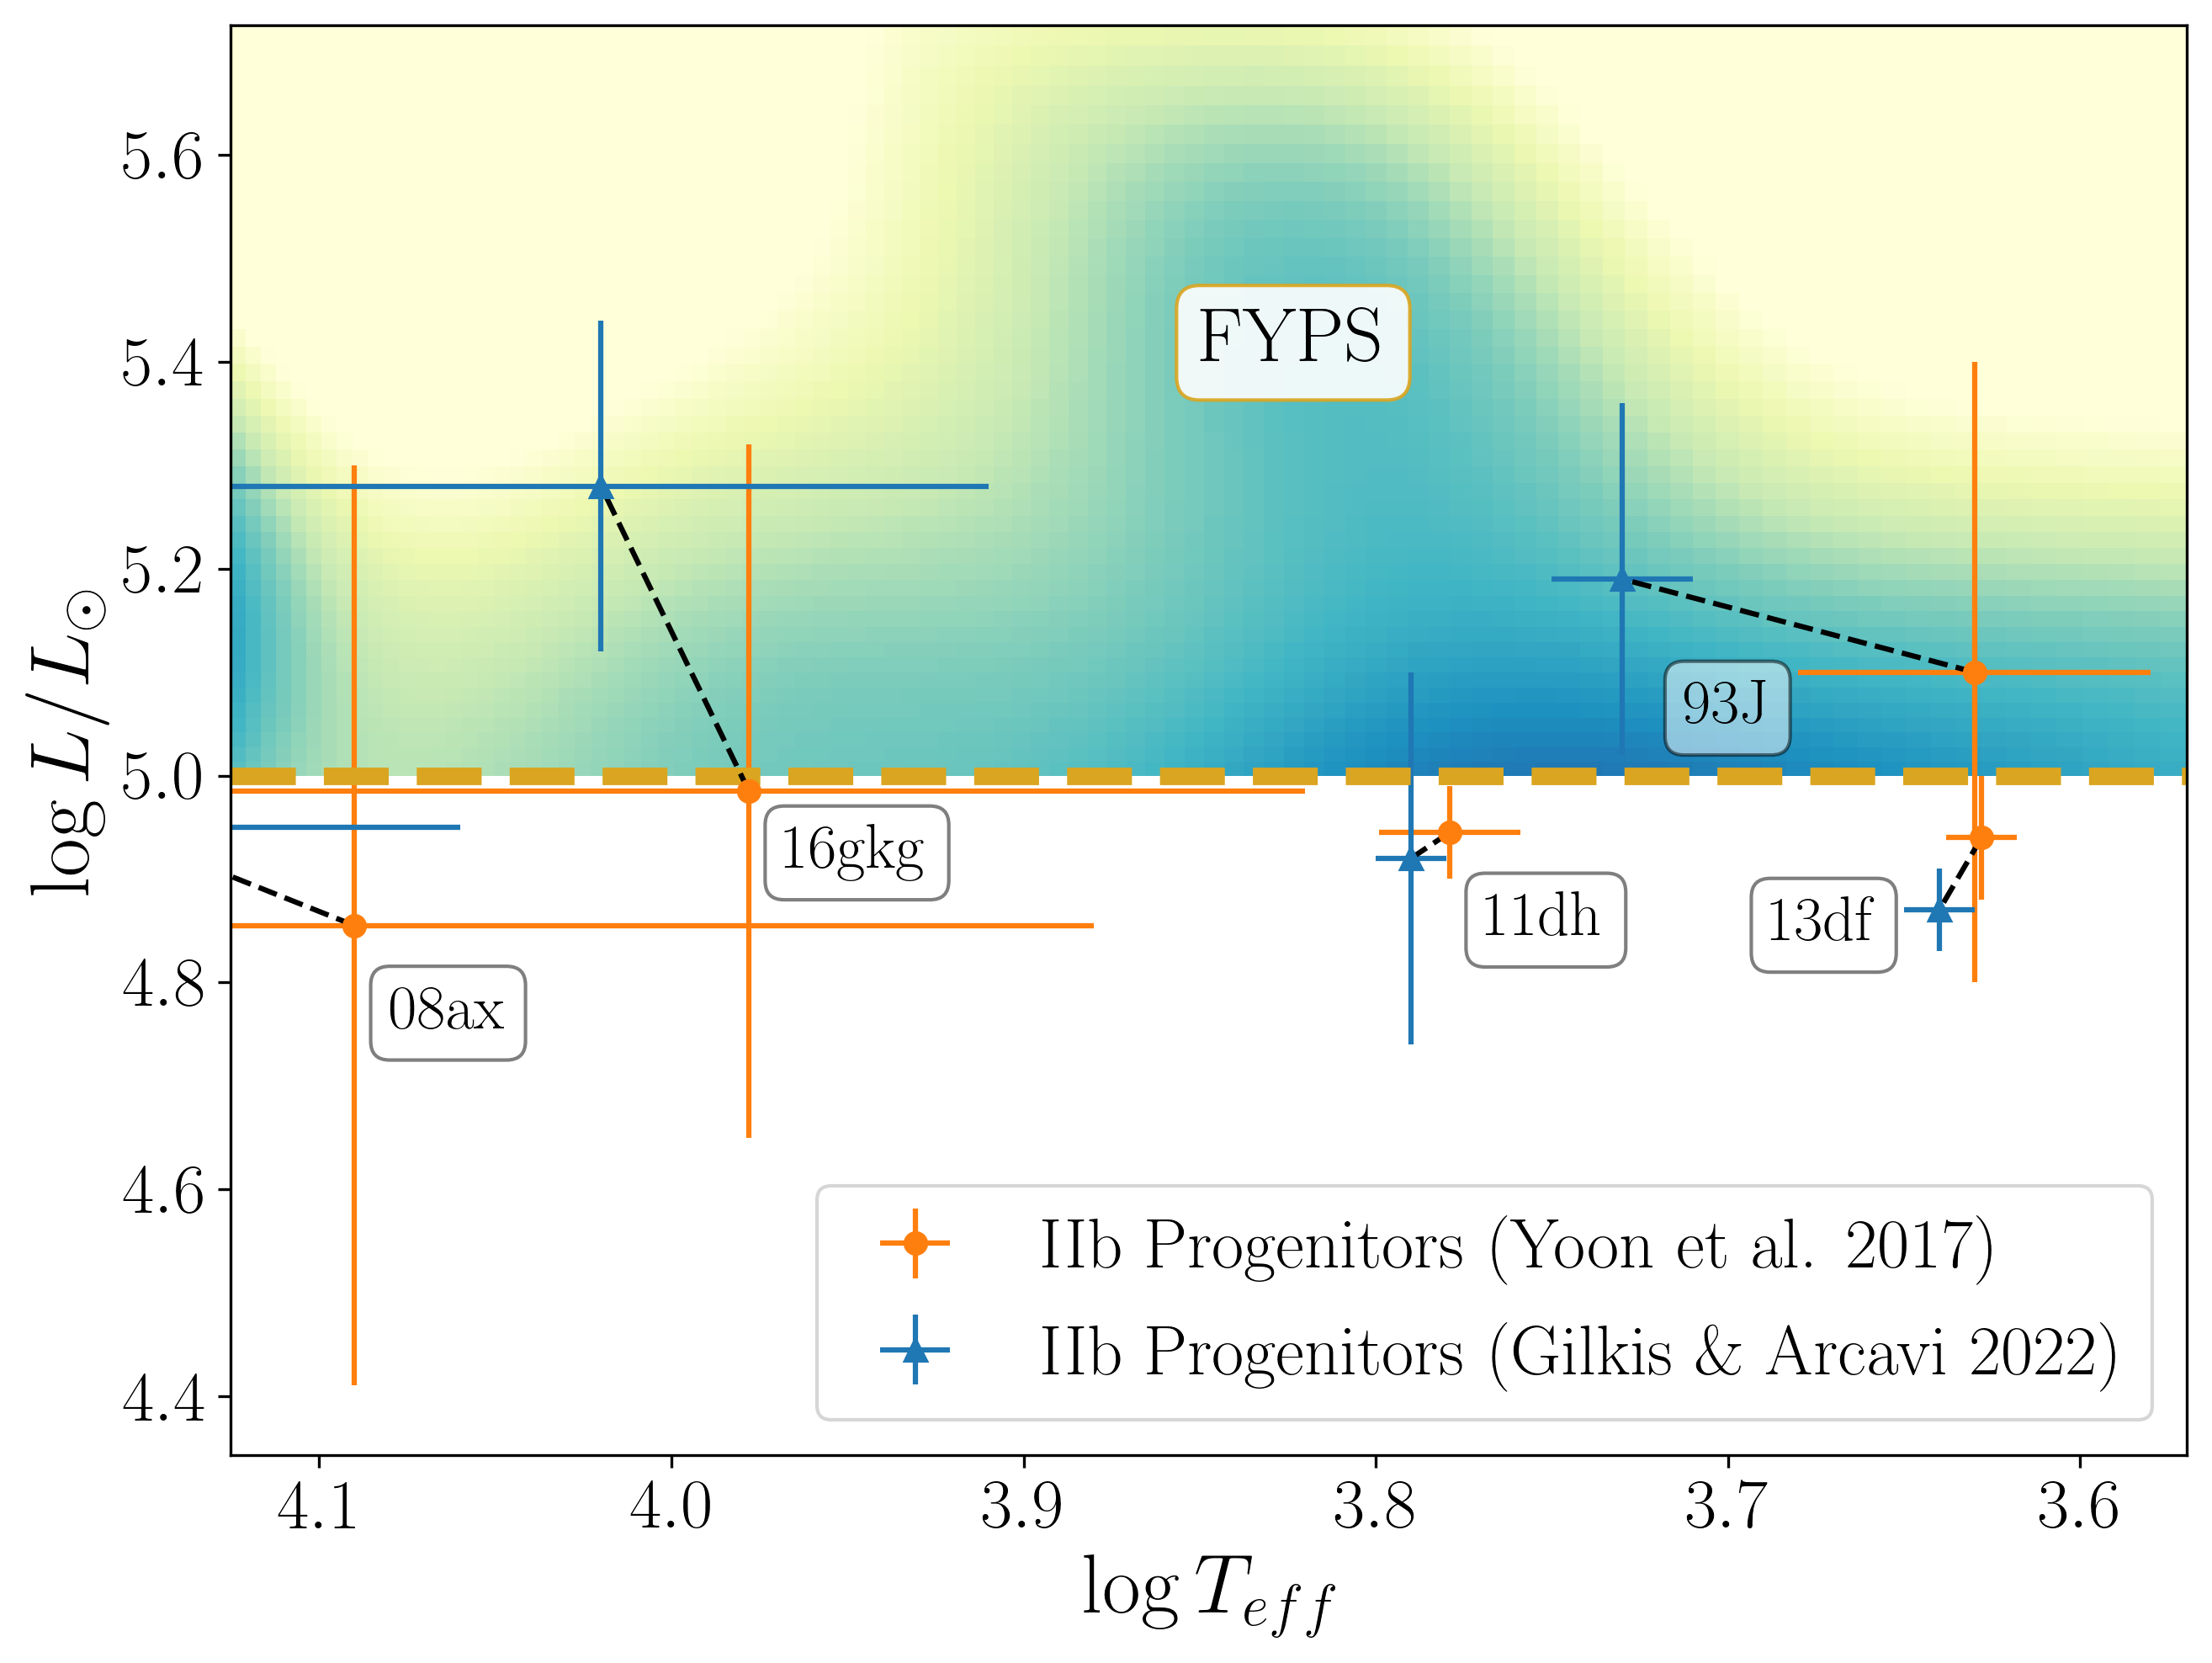

In [345]:
fig, ax = plt.subplots(1,figsize=(60/6,7.5),dpi=300)

Y_good = Y >= 5.0
mp = ax.pcolormesh(X[Y_good].reshape(44,100),Y[Y_good].reshape(44,100),(Z_pulse[Y_good].reshape(44,100)/Z_all[Y_good].reshape(44,100)) * (len(pulse_clean)/len(merged)),vmin=0.25,vmax=0.75,shading='nearest',cmap='YlGnBu_r')

ax.text(3.85,5.4,'FYPS',c='k',fontdict={'fontsize':22},rotation=0,
        bbox=dict(boxstyle="round",
                   ec='goldenrod',
                   fc='w',
                   alpha=0.9
                   ))

#ax.plot([4.1,3.6],[5.0,5.15],ls='--',lw=5,c='firebrick',zorder=1) #bottom
#ax.plot([4.1,3.6],[5.3,5.6],ls='--',lw=5,c='firebrick',zorder=1) #top
#ax.plot([4.1,4.1],[5.0,5.3],ls='--',lw=5,c='firebrick',zorder=1) #hot
#ax.plot([3.6,3.6],[5.15,5.6],ls='--',lw=5,c='firebrick',zorder=1) #cool
ax.axhline(5.0,c='goldenrod',ls='--',lw=5)
#Let's add on some SN IIb progenitors! Info from Yoon+17
# Note luminosity might be underestimated, see modelling done by Gilkis&Arcavi 22
SN_Teff = np.array([3.63, #1993J, Aldering+94, Maund+04
                    4.09, #2008ax, Folatelli+15
                    3.779, #2011dh, Maund+11, Van Dyk+11, Bersten+12
                    3.628, #2013df, Van Dyk+14
                    3.978 #2016gkg, Kilpatrick+16, Tartaglia+16
                    ])
SN_Teff_err = np.array([[0.05,0.05],
                        [0.21,0.21],
                        [0.02,0.02],
                        [0.01,0.01],
                        [0.158,0.215]
                       ]).T
SN_Teff_Gilkis = np.array([3.73,
                           4.16,
                           3.79,
                           3.64,
                           4.02])
SN_Teff_err_Gilkis = np.array([0.02,
                               0.1,
                               0.01,
                               0.01,
                               0.11])

SN_L = np.array([5.1,
                 4.855,
                 4.945,
                 4.94,
                 4.985
                ])
SN_Lerr = np.array([0.3,
                    0.445,
                    0.045,
                    0.06,
                    0.335])
SN_L_Gilkis = np.array([5.19,
                        4.95,
                        4.92,
                        4.87,
                        5.28])
SN_Lerr_Gilkis = np.array([0.17,
                           0.22,
                           0.18,
                           0.04,
                           0.16])

SN_names = ['93J','08ax','11dh','13df','16gkg']

ax.errorbar(SN_Teff,SN_L,xerr=SN_Teff_err,yerr=SN_Lerr,fmt='o',c='C1',label='IIb Progenitors (Yoon et al. 2017)')
ax.errorbar(SN_Teff_Gilkis,SN_L_Gilkis,xerr=SN_Teff_err_Gilkis,yerr=SN_Lerr_Gilkis,fmt='^',c='C0',label='IIb Progenitors (Gilkis $\&$ Arcavi 2022)')
for t,l,tg,lg in zip(SN_Teff,SN_L,SN_Teff_Gilkis,SN_L_Gilkis):
    ax.plot([t,tg],[l,lg],c='k',ls='--')
    
ax.legend(loc='lower right', fontsize=20)

for n,t,l in zip(SN_names,SN_Teff,SN_L): #zip(SN_names,SN_Teff,SN_L):
    t_offset = -0.01
    l_offset = -0.1
    if n == '93J':
        t_offset = 0.0825
        l_offset = -0.05
    elif n == '13df':
        t_offset = 0.06
    elif n == '16gkg':
        l_offset = -0.075
    ax.text(t+t_offset,l+l_offset,n,fontsize=18,
               bbox=dict(boxstyle="round",
                   ec='k',
                   fc='w',
                   alpha=0.5
                   ))
    
ax.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$',xlim=xl,ylim=yl)

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
plt.savefig('../plots/IIb_progenitors.pdf',bbox_inches='tight')

# Let's try a QuadTree histogram to see where these pulsators are living... This wound up being kinda ugly but still nice to have

In [46]:
from qthist2d import qthist, qtcount

data_all = merged[['teff','lum']].values
data_pulse = pulse_clean[['teff','lum']].values

num, xmin, xmax, ymin, ymax = qthist(data_all[:,0], data_all[:,1], N=5, thresh=4)

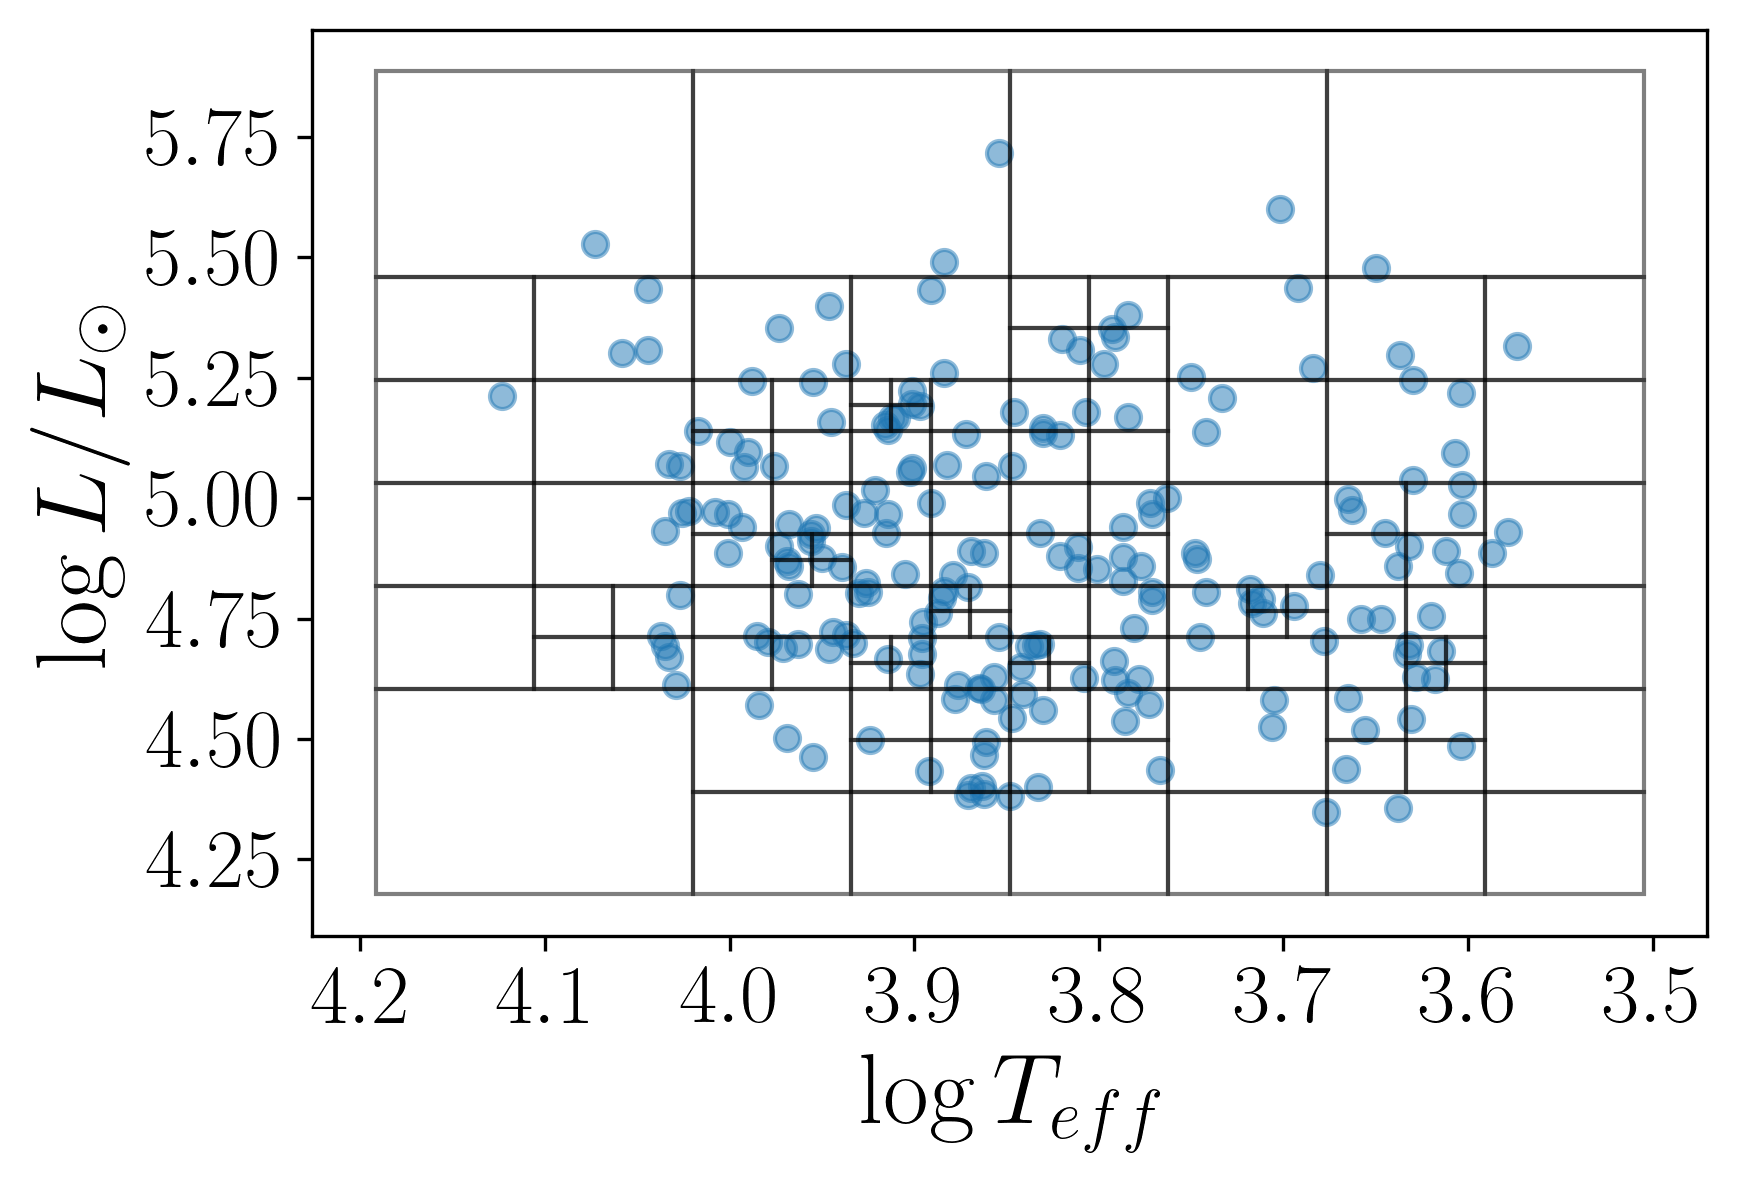

In [50]:
fig = plt.figure(dpi=300)

ax = fig.add_subplot(111)

plt.scatter(data_all[:,0], data_all[:,1], alpha=0.5)

for k in range(len(num)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               fc ='none', ec='k', alpha=0.5))

    
ax.invert_xaxis() 
ax.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$')

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

In [106]:
num, xmin, xmax, ymin, ymax = qthist(data_all[:,0],data_all[:,1], N=6, thresh=6, density=False)

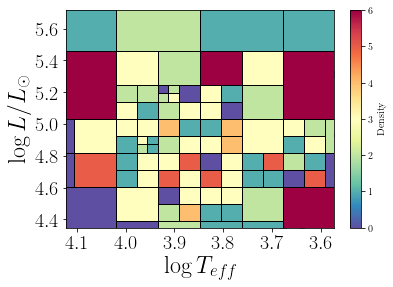

In [107]:
fig = plt.figure()

ax = fig.add_subplot(111)

CMAP = plt.cm.Spectral_r

clr = (num - np.nanmin(num)) / (np.nanmax(num) - np.nanmin(num))

for k in range(len(num)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               fc =CMAP(clr[k]), ec='k', alpha=1))

# create a fake image, just to invoke colormap
img = plt.imshow(np.array([[0,1]]), cmap=CMAP, aspect='auto',origin='lower', 
                 vmin=num.min(),vmax=num.max()) # scale to the density
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label('Density')

plt.scatter(data_all[:,0], data_all[:,1], alpha=0.5)

ax.invert_xaxis() 
ax.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$',xlim=(data_all[:,0].max(),data_all[:,0].min()),
                                                              ylim=(data_all[:,1].min(),data_all[:,1].max()))

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

In [108]:
num_pulse = qtcount(data_pulse[:,0], data_pulse[:,1], xmin, xmax, ymin, ymax, density=False)

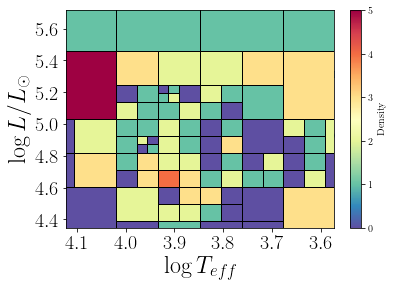

In [109]:
fig = plt.figure()

ax = fig.add_subplot(111)

CMAP = plt.cm.Spectral_r

clr = (num_pulse - np.nanmin(num_pulse)) / (np.nanmax(num_pulse) - np.nanmin(num_pulse))

for k in range(len(num_pulse)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               fc =CMAP(clr[k]), ec='k', alpha=1))

# create a fake image, just to invoke colormap
img = plt.imshow(np.array([[0,1]]), cmap=CMAP, aspect='auto',origin='lower', 
                 vmin=num_pulse.min(),vmax=num_pulse.max()) # scale to the density
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label('Density')

plt.scatter(data_pulse[:,0], data_pulse[:,1], alpha=0.5)

ax.invert_xaxis() 
ax.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$',xlim=(data_all[:,0].max(),data_all[:,0].min()),
                                                              ylim=(data_all[:,1].min(),data_all[:,1].max()))

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

In [110]:
f_pulse = num_pulse/num

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(array([15.,  0.,  2.,  7.,  3., 13., 10.,  1.,  2., 24.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

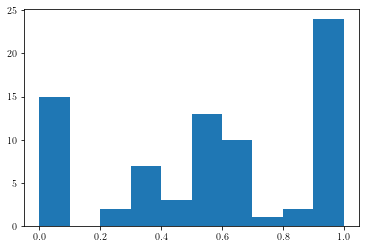

In [111]:
plt.hist(f_pulse)

In [114]:
f_pulse.nanmin()

AttributeError: 'numpy.ndarray' object has no attribute 'nanmin'

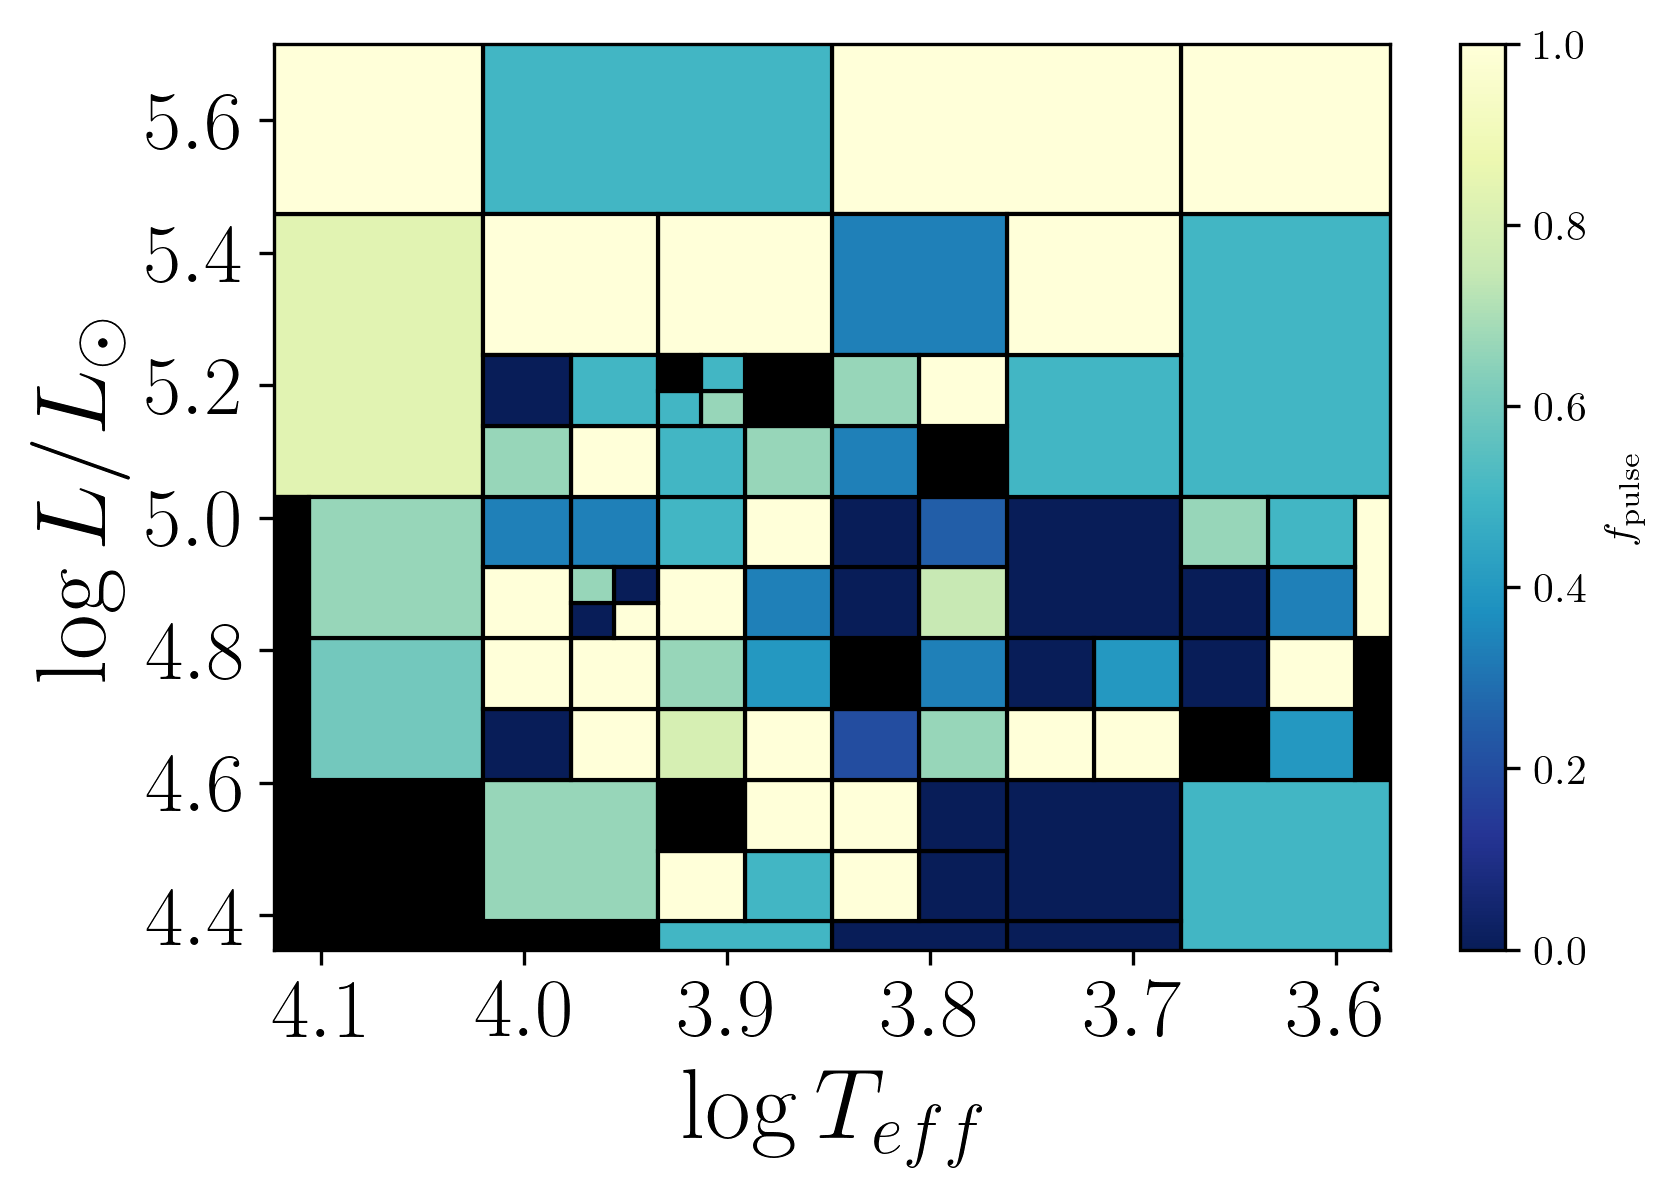

In [112]:
fig = plt.figure(dpi=300)

ax = fig.add_subplot(111)

CMAP = plt.cm.YlGnBu_r

clr = (f_pulse - np.nanmin(f_pulse)) / (np.nanmax(f_pulse) - np.nanmin(f_pulse))

for k in range(len(f_pulse)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               fc=CMAP(clr[k]), ec='k', alpha=1))

# create a fake image, just to invoke colormap
img = plt.imshow(np.array([[0,1]]), cmap=CMAP, aspect='auto',origin='lower', 
                 vmin=0,vmax=1) # scale to the density
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label(r'$f_{\rm pulse}$')

plt.scatter(data_all[:,0], data_all[:,1], alpha=0.5)

ax.invert_xaxis() 
ax.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$',xlim=(data_all[:,0].max(),data_all[:,0].min()),
                                                              ylim=(data_all[:,1].min(),data_all[:,1].max()))

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

In [115]:
f_pulse.shape

(88,)

In [118]:
#Where are these overdensities statistically significant?
N_trials = 10000
f_stack = np.empty((N_trials,*f_pulse.shape))

random_state = np.random.RandomState(seed=42)
for i in tqdm(range(N_trials)):
    random_sample = merged.sample(n=len(pulse_clean),replace=False,random_state=random_state)
    
    data_trial = random_sample[['teff','lum']].values
    num_trial = qtcount(data_trial[:,0], data_trial[:,1], xmin, xmax, ymin, ymax, density=False)
    
    f_trial = num_trial/num

    f_stack[i] = f_trial

good = f_pulse > f_stack
f_gtr = good.sum(axis=0)/N_trials

  0%|          | 0/10000 [00:00<?, ?it/s]

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


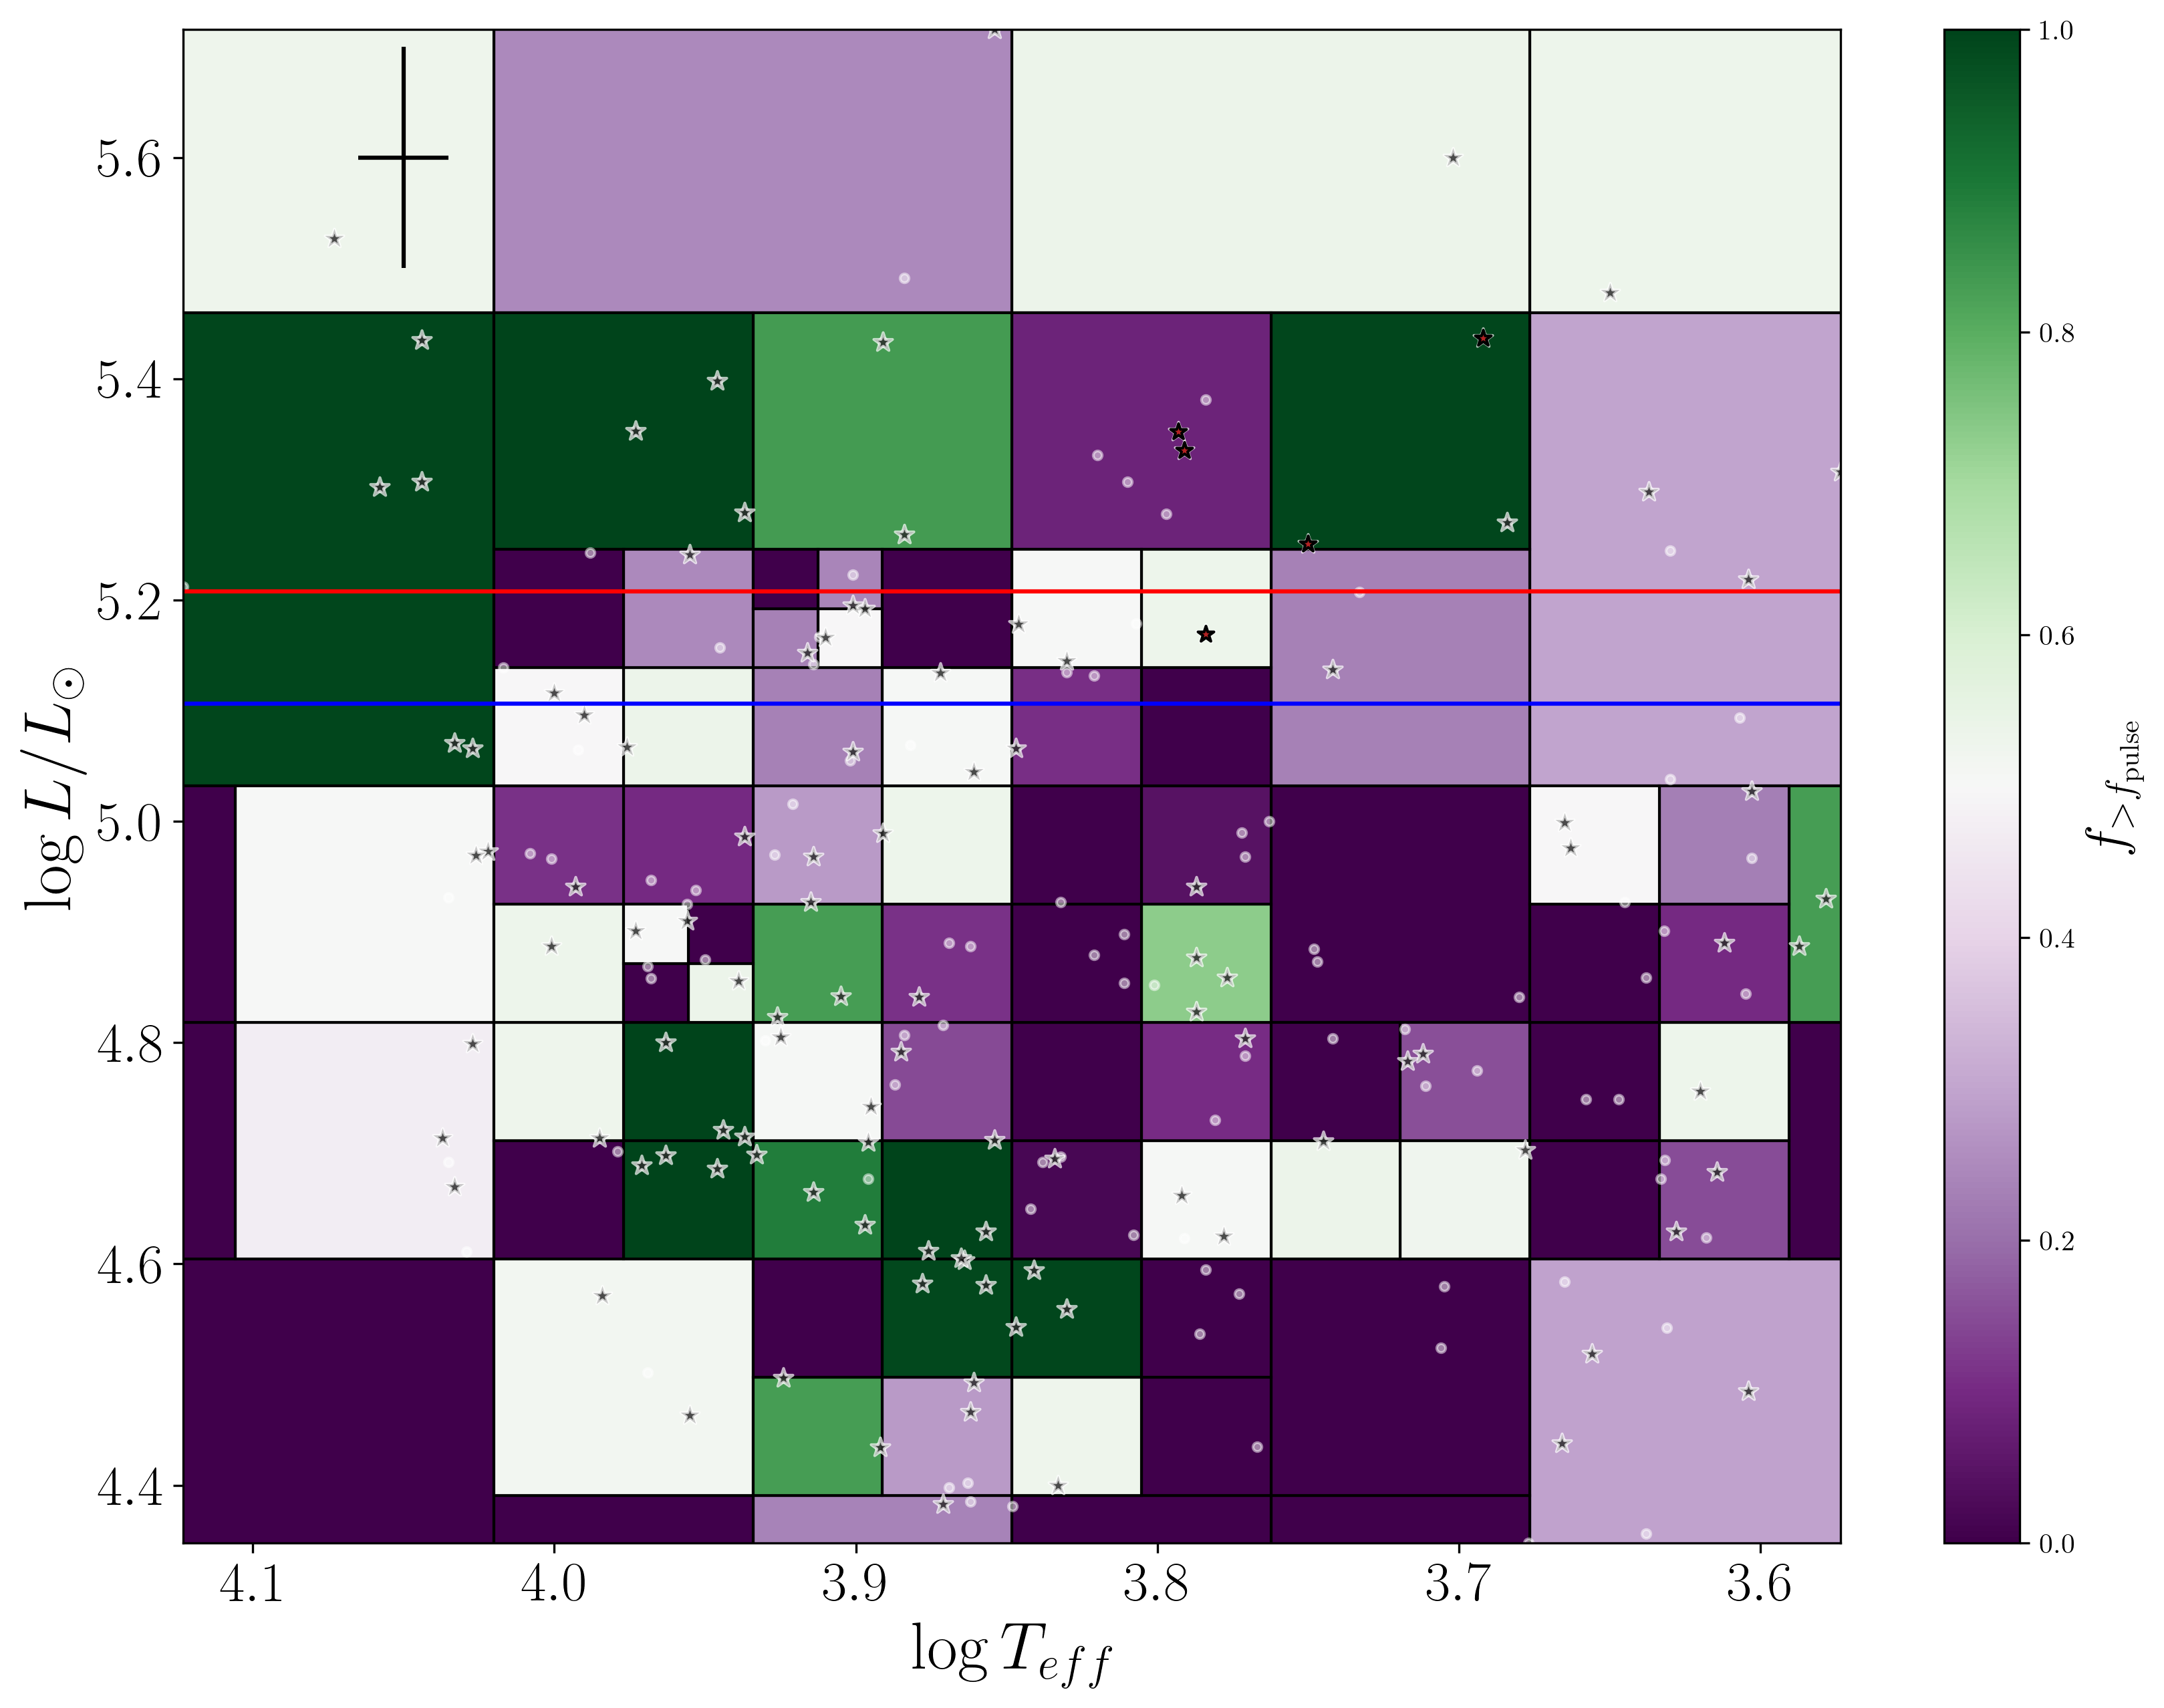

In [133]:
fig = plt.figure(figsize=(80/6,10),dpi=300)

ax = fig.add_subplot(111)

CMAP = plt.cm.PRGn

clr = (f_gtr - np.nanmin(f_gtr)) / (np.nanmax(f_gtr) - np.nanmin(f_gtr))

for k in range(len(f_gtr)):
    ax.add_patch(plt.Rectangle((xmin[k], ymin[k]), xmax[k]-xmin[k], ymax[k]-ymin[k], 
                               fc=CMAP(clr[k]), ec='k', alpha=1))

# create a fake image, just to invoke colormap
img = plt.imshow(np.array([[0,1]]), cmap=CMAP, aspect='auto',origin='lower', 
                 vmin=0,vmax=1) # scale to the density
img.set_visible(False) # throw this away
cb = plt.colorbar()
cb.set_label(r'$f_{> f_{\rm pulse}}$',fontsize=20)

plt.scatter(merged['teff'],merged['lum'],c='w', alpha=0.5, zorder=2, s=10)
plt.scatter(pulse_clean['teff'],pulse_clean['lum'],marker='*',c='k',edgecolor='w', alpha=0.7, zorder=2, s=50)
#plt.scatter(candidate_fyps['teff'],candidate_fyps['lum'],c='grey',marker='*')
plt.scatter(fyps['teff'],fyps['lum'],c='firebrick',marker='*',edgecolor='k',zorder=2)
"""plt.text(3.875,5.3,'FYPS',c='k',fontdict={'fontsize':22},rotation=8,
        bbox=dict(boxstyle="round",
                   ec='firebrick',
                   fc='w',
                   alpha=0.5
                   ))
plt.plot([4.1,3.6],[5.0,5.15],ls='--',lw=5,c='firebrick',zorder=1)
plt.plot([4.1,3.6],[5.3,5.6],ls='--',lw=5,c='firebrick',zorder=1)
plt.plot([4.1,4.1],[5.0,5.3],ls='--',lw=5,c='firebrick',zorder=1)
plt.plot([3.6,3.6],[5.15,5.6],ls='--',lw=5,c='firebrick',zorder=1)



from matplotlib.patches import Ellipse
plt.text(3.99,4.6,r'$\alpha$ Cyg',c='k',fontdict={'fontsize':22},rotation=0,
        bbox=dict(boxstyle="round",
                   ec='slateblue',
                   fc='w',
                   alpha=0.5))

cx = 3.975
cy = 4.625
a_x = 0.4
a_y = 0.45
theta = -30
num1 = np.power(np.cos(np.deg2rad(theta))*(pulse_clean['teff']-cx) + np.sin(np.deg2rad(theta))*(pulse_clean['lum']-cy), 2.0)
den1 = (a_x/2.0) ** 2.0
num2 = np.power(np.sin(np.deg2rad(theta))*(pulse_clean['teff']-cx) - np.cos(np.deg2rad(theta))*(pulse_clean['lum']-cy), 2.0)
den2 = (a_y/2.0) ** 2.0
in_ellipse = pulse_clean[num1/den1 + num2/den2 <= 1.0]
plt.scatter(in_ellipse['teff'],in_ellipse['lum'],c='grey',marker='*')
ax.add_patch(Ellipse((cx, cy), a_x, a_y, angle=theta, fill=False,edgecolor='slateblue',lw=5))



#Plot Cepheid strip
ln1 = plt.plot(instability_strip['logTeff1'],instability_strip['logL1'],lw=5,c='b')
ln2 = plt.plot(instability_strip['logTeff2'],instability_strip['logL2'],lw=5,c='r')
inst_t = np.array([s['logTeff1'] for _,s in instability_strip.iterrows()])
inst_l = np.array([s['logL1'] for _,s in instability_strip.iterrows()])
for i,s in instability_strip.iterrows():
    if i == 0:
        inst_t = np.append(inst_t,s['logTeff2'])
        inst_l = np.append(inst_l,s['logL2'])
    else:
        inst_t = np.insert(inst_t,-1*i,s['logTeff2'])
        inst_l = np.insert(inst_l,-1*i,s['logL2'])
coords = np.hstack((inst_t[:,np.newaxis],inst_l[:,np.newaxis]))
poly = plt.Polygon(coords,fc='wheat',alpha=0.5,hatch='//')
ax.add_patch(poly)
plt.text(3.7,4.45,'Cepheids',fontdict={'fontsize':20},rotation=80,
        bbox=dict(boxstyle="round",
                   ec='wheat',
                   fc='w',
                   alpha=0.5
                   ))"""

def Mi_to_L(M):
    """
    Computes Eq (2) of Kochanek (2020) to convert between an initial mass and final luminosity
    """
    term1 = 4.610
    term2 = 2.267*np.log10(M/10.0)
    term3 = -0.494*((np.log10(M/10.0)) ** 2.0)
    return term1 + term2 + term3

L_max = Mi_to_L(19.1) # from Table 1, Kochanek (2020)
"""L_upp = Mi_to_L(19.1+4.04)
L_low = Mi_to_L(19.1-2.04)

ax.axhspan(L_low,L_upp,hatch='XX',alpha=0.5)"""
ax.axhline(y=L_max,c='r')
ax.axhline(y=Mi_to_L(17.0),c='b') #and 17 Msun

ax.errorbar(4.05,5.6,xerr=0.015,yerr=0.1,zorder=10,c='k')


ax.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$',xlim=(data_all[:,0].max(),data_all[:,0].min()),
                                                              ylim=(data_all[:,1].min(),data_all[:,1].max()))

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
plt.savefig('../plots/quadtree_ffpulse.pdf',bbox_inches='tight')